In [1]:
from openbb import obb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vectorbt as vbt
import pyfolio as pf
import ta
import shap
import cvxpy as cp
from datetime import datetime
import quantstats as qs

import tensorflow as tf
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
%matplotlib inline

# Data

In [76]:
# Fetch data using OpenBB
def fetch_data(tickers, start, end):
    combined = []
    for ticker in tickers:
        try:
            data = obb.equity.price.historical(
                ticker,
                start_date=start,
                end_date=end,
                provider="yfinance"
            ).to_dataframe()
            if not data.empty:
                data['Ticker'] = ticker
                combined.append(data)
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    if combined:
        return pd.concat(combined).reset_index()
    return pd.DataFrame()

In [77]:
# Fetch S&P 500 tickers
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_tickers = pd.read_html(url)[0]['Symbol'].tolist()

In [78]:
# Define date range
start_date = "2015-01-01"
end_date = "2023-12-31"

In [79]:
# Define tickers
stock_data = fetch_data(sp500_tickers[:10], start_date, end_date)
sp500_data = fetch_data(['^GSPC'], start_date, end_date)

In [86]:
sp500_data['Returns'] = sp500_data.groupby('Ticker')['close'].pct_change()
sp500_daily_returns = sp500_data['Returns']

# Convert 'date' column to datetime format
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

# Set the 'date' column as the index
sp500_data = sp500_data.set_index('date')

# Create sp500_daily_returns with datetime index
sp500_daily_returns = sp500_data['Returns']

print("SP500 daily returns with datetime index:\n", sp500_daily_returns.head())

SP500 daily returns with datetime index:
 date
2015-01-02         NaN
2015-01-05   -0.018278
2015-01-06   -0.008893
2015-01-07    0.011630
2015-01-08    0.017888
Name: Returns, dtype: float64


## Adding Features

In [46]:
# Feature Engineering
def add_features(df):
    df = df.sort_values(["Ticker", "date"])
    
    # Add technical indicators using the ta library
    df["RSI"] = ta.momentum.RSIIndicator(close=df["close"]).rsi()
    macd = ta.trend.MACD(close=df["close"])
    df["MACD"] = macd.macd()
    df["MACD_Signal"] = macd.macd_signal()
    df["MACD_Diff"] = macd.macd_diff()  # Histogram difference
    bollinger = ta.volatility.BollingerBands(close=df["close"])
    df["Bollinger_Upper"] = bollinger.bollinger_hband()
    df["Bollinger_Lower"] = bollinger.bollinger_lband()
    df["Bollinger_Middle"] = bollinger.bollinger_mavg()  # Middle band (SMA)
    
    # Drop NaN values resulting from indicator calculations
    df = df.dropna()
    
    return df

In [47]:
stock_data = add_features(stock_data)

# Correlation Matrix

In [48]:
numeric_columns = stock_data.select_dtypes(include=[float, int])

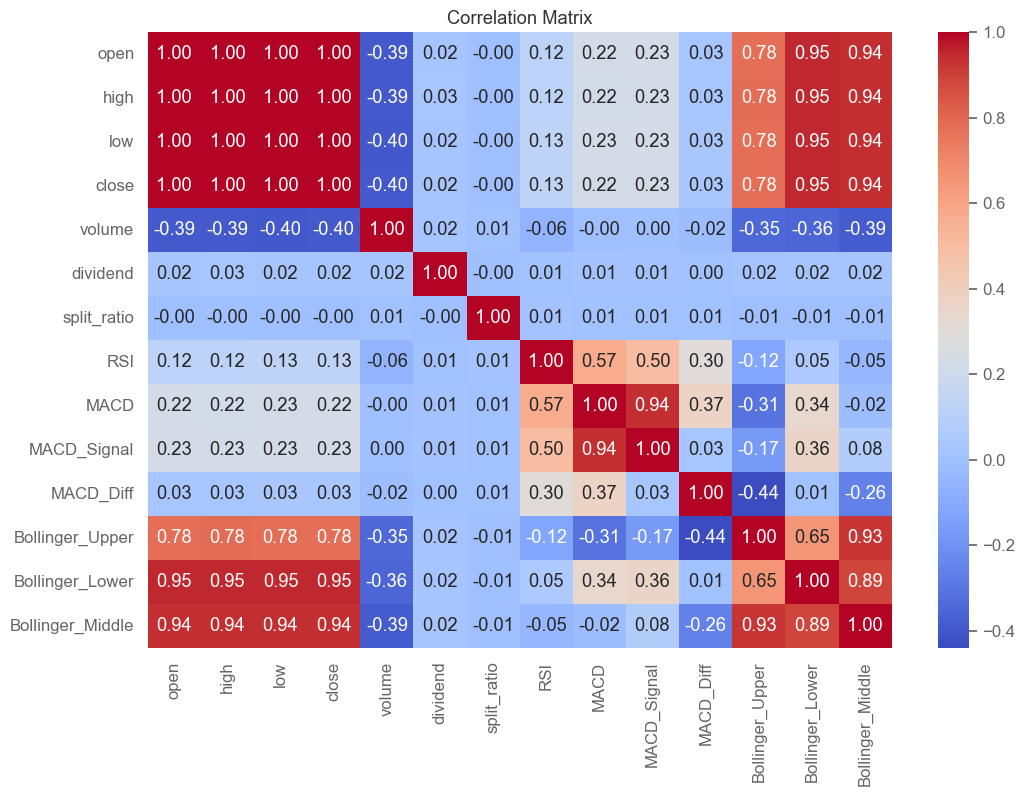

In [49]:
# Compute correlation matrix
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Random Forest Classifier

In [50]:
# Features and Target Preparation
features = [
    "RSI",
    "MACD",
    "MACD_Signal",
    "MACD_Diff",
    "Bollinger_Upper",
    "Bollinger_Lower",
    "Bollinger_Middle",
]
stock_data = add_features(stock_data)  # Apply feature engineering
X = stock_data[features]
y = (stock_data["close"].shift(-1) > stock_data["close"]).astype(int)

In [51]:
# Drop NaNs resulting from feature engineering and target shift
X = X.dropna()
y = y.loc[X.index]  # Align target with features

In [52]:
# List to store SHAP values and feature importance for each split
all_shap_values = []
all_feature_importance = []

In [53]:
# Walk-Forward Validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # Adjust number of splits as needed

Split 1:
Classification Report for Split 1:
              precision    recall  f1-score   support

           0       0.47      0.79      0.59       342
           1       0.59      0.25      0.35       407

    accuracy                           0.50       749
   macro avg       0.53      0.52      0.47       749
weighted avg       0.53      0.50      0.46       749

Running SHAP analysis for Split 1...


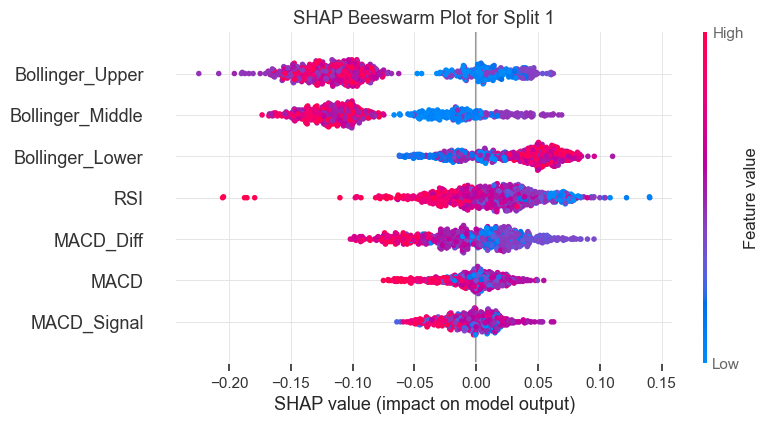

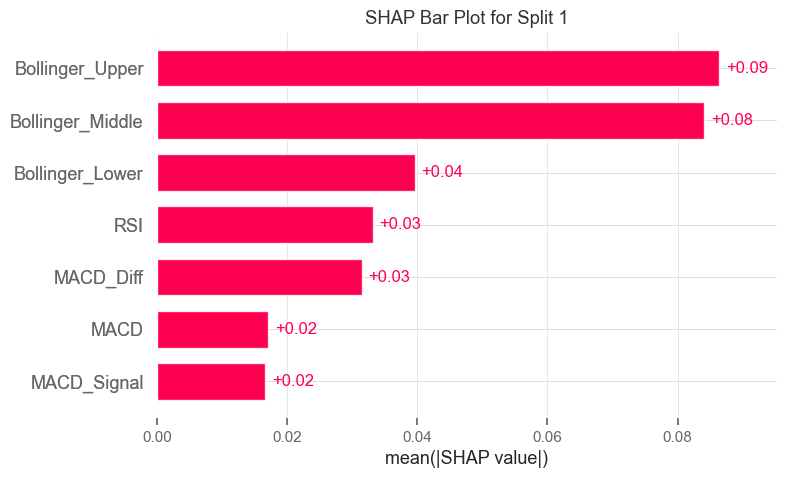

Split 2:
Classification Report for Split 2:
              precision    recall  f1-score   support

           0       0.46      0.84      0.59       341
           1       0.55      0.16      0.25       408

    accuracy                           0.47       749
   macro avg       0.51      0.50      0.42       749
weighted avg       0.51      0.47      0.41       749

Running SHAP analysis for Split 2...


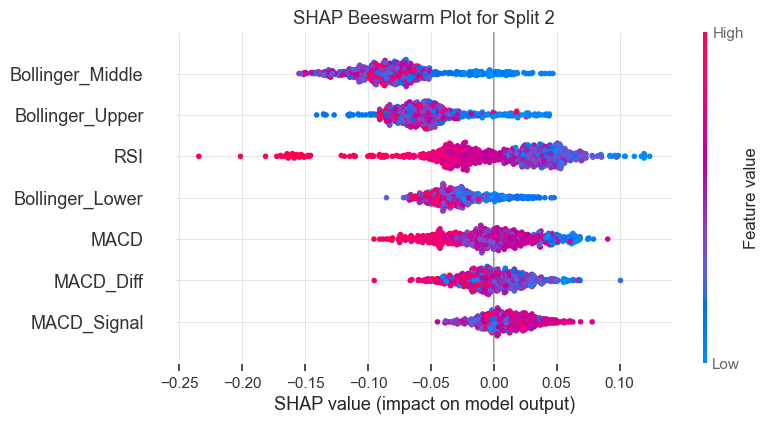

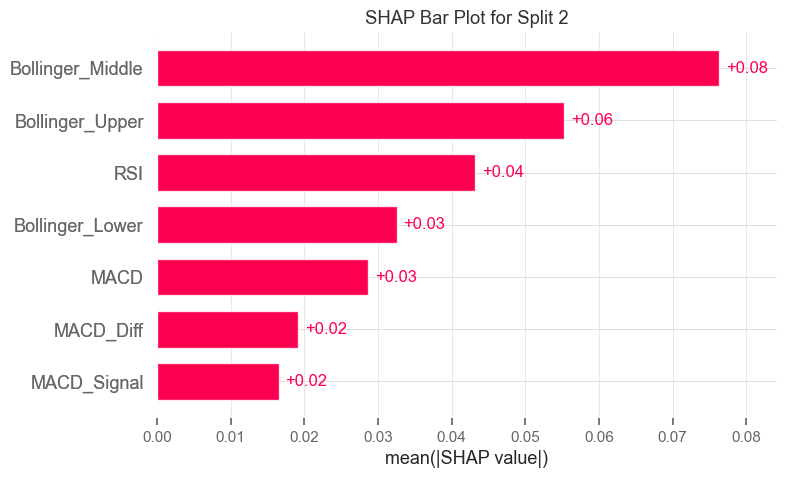

Split 3:
Classification Report for Split 3:
              precision    recall  f1-score   support

           0       0.47      0.34      0.40       328
           1       0.58      0.70      0.63       421

    accuracy                           0.54       749
   macro avg       0.52      0.52      0.51       749
weighted avg       0.53      0.54      0.53       749

Running SHAP analysis for Split 3...


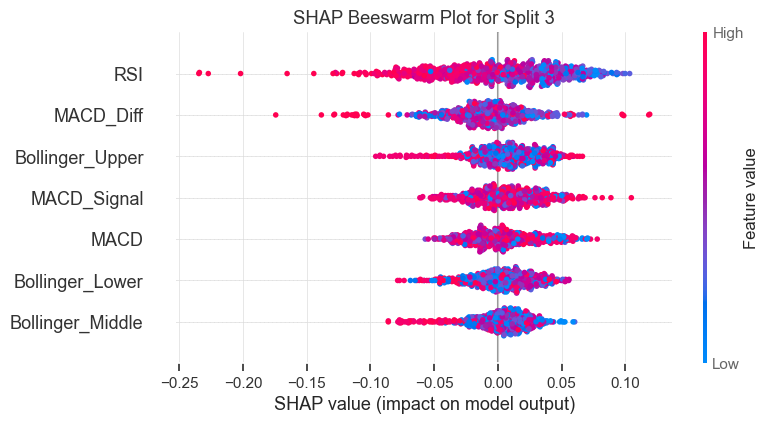

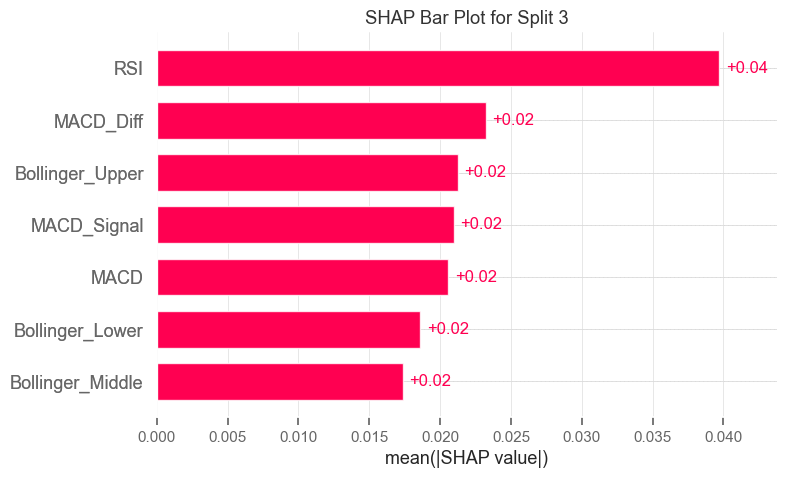

Split 4:
Classification Report for Split 4:
              precision    recall  f1-score   support

           0       0.54      0.33      0.41       359
           1       0.55      0.74      0.63       390

    accuracy                           0.55       749
   macro avg       0.55      0.54      0.52       749
weighted avg       0.55      0.55      0.53       749

Running SHAP analysis for Split 4...


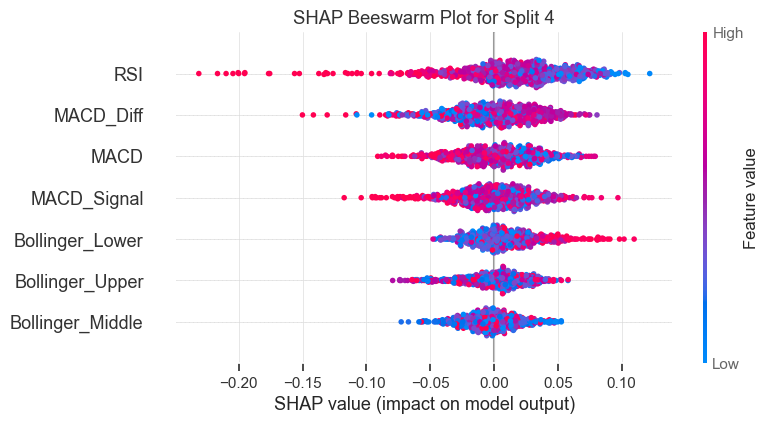

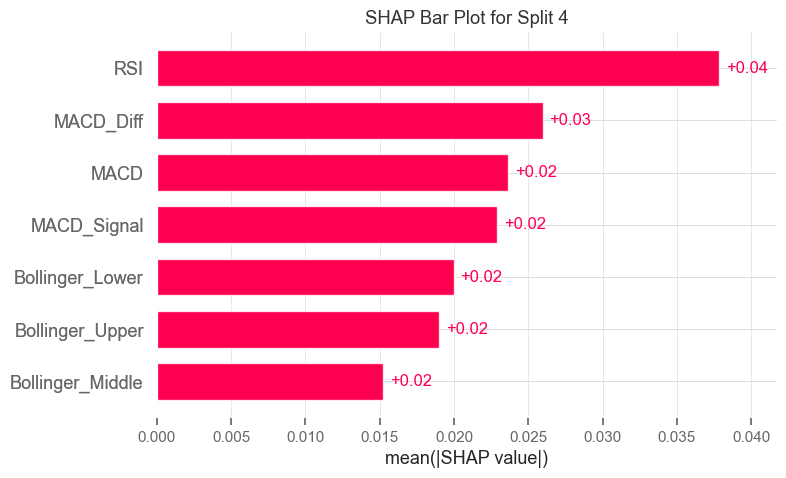

Split 5:
Classification Report for Split 5:
              precision    recall  f1-score   support

           0       0.49      0.52      0.50       379
           1       0.47      0.44      0.45       370

    accuracy                           0.48       749
   macro avg       0.48      0.48      0.48       749
weighted avg       0.48      0.48      0.48       749

Running SHAP analysis for Split 5...


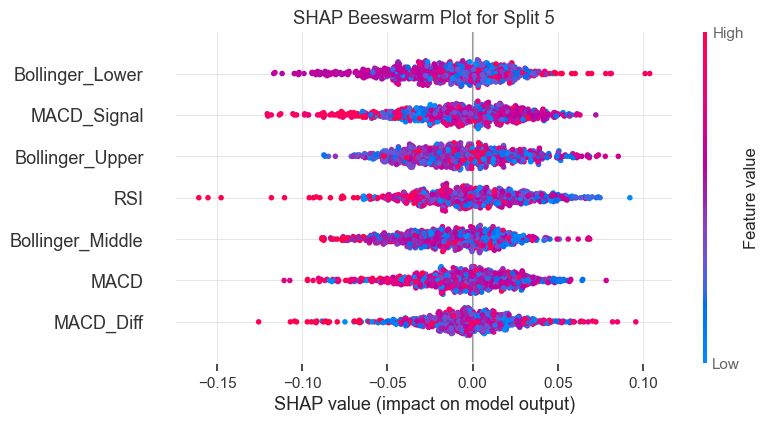

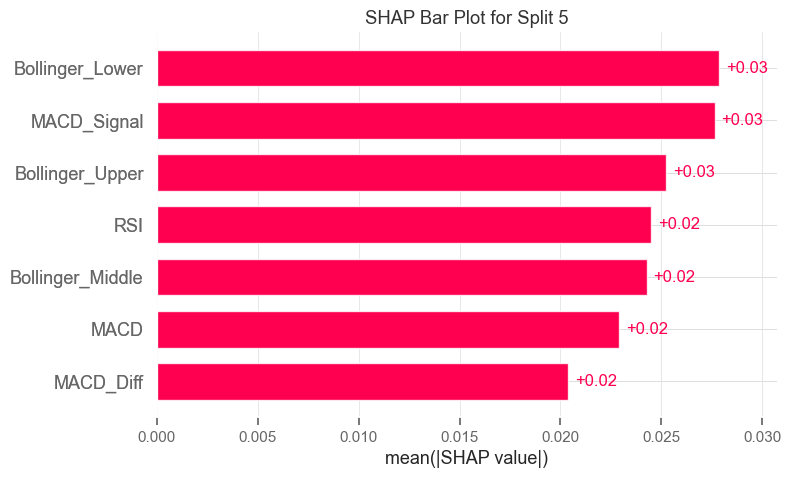

In [54]:
#Walk-forward validation loop
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Split {i + 1}:")
    
    # Split data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    print(f"Classification Report for Split {i + 1}:")
    print(classification_report(y_test, y_pred))
    
    # Store predictions for analysis or backtesting
    stock_data.loc[X_test.index, f"Predicted_Signal_Split_{i + 1}"] = y_pred

    # SHAP Analysis
    print(f"Running SHAP analysis for Split {i + 1}...")
    explainer = shap.TreeExplainer(model)

    # For newer SHAP versions, shap_values can be shape (n_samples, n_features, n_classes)
    shap_values = explainer.shap_values(X_test)

    # Select the SHAP values for the positive class (class index 1)
    # This gives us a 2D array of shape (n_samples, n_features)
    shap_values_class_1 = shap_values[:, :, 1]

    # Handle base value for the positive class if explainer.expected_value is a list
    if isinstance(explainer.expected_value, list):
        base_value_class_1 = explainer.expected_value[1]
    else:
        base_value_class_1 = explainer.expected_value

    # Build a shap.Explanation object
    expl = shap.Explanation(
        values=shap_values_class_1,
        base_values=base_value_class_1,
        data=X_test,
        feature_names=X_test.columns
    )

 
    # Beeswarm plot
    shap.plots.beeswarm(expl, show=False)
    plt.title(f"SHAP Beeswarm Plot for Split {i + 1}")
    plt.show()

    # Bar plot (global feature importance)
    shap.plots.bar(expl, show=False)
    plt.title(f"SHAP Bar Plot for Split {i + 1}")
    plt.show()

    # Store SHAP values for global analysis
    all_shap_values.append(shap_values_class_1)
    all_feature_importance.append(np.mean(np.abs(shap_values_class_1), axis=0))  # Global importance

In [55]:
# Combine SHAP feature importance across all splits
mean_feature_importance = np.mean(all_feature_importance, axis=0)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Importance': mean_feature_importance
}).sort_values(by='Mean Importance', ascending=False)

In [56]:
# Display aggregated feature importance
print("\nAggregated SHAP Feature Importance:")
print(importance_df)


Aggregated SHAP Feature Importance:
            Feature  Mean Importance
6  Bollinger_Middle         0.043469
4   Bollinger_Upper         0.041431
0               RSI         0.035690
5   Bollinger_Lower         0.027720
3         MACD_Diff         0.024047
1              MACD         0.022592
2       MACD_Signal         0.020958


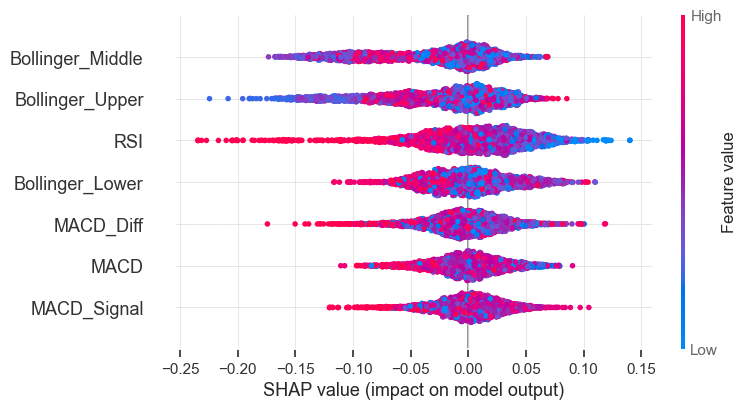

In [57]:
# Concatenate all SHAP values across splits
combined_shap_values = np.concatenate(all_shap_values, axis=0)

# Gather all test indices (in the same order you appended SHAP arrays)
all_test_indices = []
for _, test_index in tscv.split(X):
    all_test_indices.extend(test_index)
all_test_indices = np.array(all_test_indices)

# Select from X using those test indices
X_all_test = X.iloc[all_test_indices]

# Plot global SHAP summary
shap.summary_plot(combined_shap_values, X_all_test)

In [58]:
# Combine predictions into a single column
stock_data["Predicted_Signal"] = stock_data[[f"Predicted_Signal_Split_{i + 1}" for i in range(tscv.n_splits)]].sum(axis=1)
stock_data["Predicted_Signal"] = stock_data["Predicted_Signal"].apply(lambda x: 1 if x > 0 else 0)  # Final prediction

In [59]:
def backtest_strategy(df, freq="1D"):
    # Make a copy to avoid mutating the original DataFrame
    df = df.copy()

    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Pivot 'close' so each ticker is in a separate column; index is 'date'
    close_wide = df.pivot(index="date", columns="Ticker", values="close")
    # Ensure the pivot index is a proper DatetimeIndex
    close_wide.index = pd.to_datetime(close_wide.index)

    # Pivot 'Predicted_Signal' for multi-column signals
    signal_wide = df.pivot(index="date", columns="Ticker", values="Predicted_Signal")
    # Convert this index too, just to be safe
    signal_wide.index = pd.to_datetime(signal_wide.index)

    # Create boolean DataFrames for entries/exits
    entries_wide = signal_wide == 1
    exits_wide = signal_wide == 0

    # Build Portfolio
    pf_data = vbt.Portfolio.from_signals(
        close=close_wide,
        entries=entries_wide,
        exits=exits_wide,
        size=np.inf,
        direction="longonly",
        cash_sharing=True,
        freq=freq
    )
    return pf_data

In [60]:
# Run the updated backtest
portfolio = backtest_strategy(stock_data)

In [61]:
# Performance Metrics
print("Portfolio Performance Metrics:")
print(f"Total Return: {portfolio.total_return():.2%}")
print(f"Annualized Return: {portfolio.annualized_return():.2%}")
print(f"Max Drawdown: {portfolio.max_drawdown():.2%}")
print(f"Sharpe Ratio: {portfolio.sharpe_ratio():.2f}")
print(f"Calmar Ratio: {portfolio.calmar_ratio():.2f}")

Portfolio Performance Metrics:
Total Return: 430.11%
Annualized Return: 30.85%
Max Drawdown: -34.22%
Sharpe Ratio: 1.12
Calmar Ratio: 0.90


In [62]:
# VectorBT Charts
portfolio.plot()  # Works for the entire portfolio
portfolio.drawdowns.plot()  # Drawdown analysis

# Ungroup trades to analyze each ticker separately
ungrouped_trades = portfolio.trades.regroup(group_by=False)

# Trade analysis for each ticker in the grouped portfolio
for ticker in portfolio.wrapper.columns:
    if ticker in ungrouped_trades.records_readable['Column'].unique():
        print(f"Plotting trades for {ticker}...")  # Debugging info
        # Select trades for the specific ticker
        trades_for_ticker = ungrouped_trades.select_one(column=ticker)
        fig = trades_for_ticker.plot()  # Get the figure for the plot
        fig.show()  # Explicitly show the figure

# Explicitly show all plots
plt.show()

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



Plotting trades for AFL...


Plotting trades for AOS...


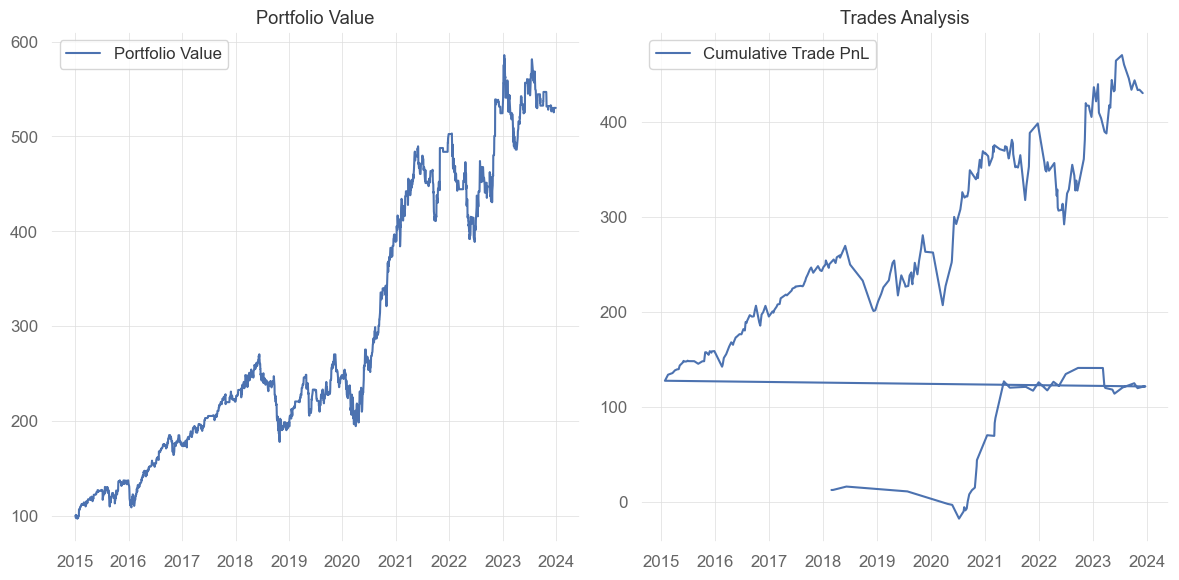

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'group',
              'showlegend': True,
              'type': 'scatter',
              'uid': '9f73d123-e05b-42a6-93ee-806bc1e99b73',
              'x': array([datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 5, 0, 0),
                          datetime.datetime(2015, 1, 6, 0, 0), ...,
                          datetime.datetime(2023, 12, 27, 0, 0),
                          datetime.datetime(2023, 12, 28, 0, 0),
                          datetime.datetime(2023, 12, 29, 0, 0)], dtype=object),
              'y': array([100.        ,  98.25031321,  97.44689067, ..., 530.10657417,
                          530.10657417, 530.10657417])},
             {'customdata': array([[16],
                                   [59],
                                   [81],
                                   [82],
                                   [85]], dtype=int64),
             

In [63]:
# Matplotlib figure for portfolio value and trades
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Portfolio value (Matplotlib)
axes[0].plot(portfolio.value().index, portfolio.value(), label="Portfolio Value")
axes[0].set_title("Portfolio Value")
axes[0].legend()

# Trades analysis (Matplotlib)
if not portfolio.trades.records_readable.empty:  # Check if trades data is available
    trades_pnl = portfolio.trades.records_readable['PnL'].cumsum()
    trades_pnl.index = pd.to_datetime(portfolio.trades.records_readable['Exit Timestamp'])  # Use timestamps for plotting
    axes[1].plot(trades_pnl.index, trades_pnl, label="Cumulative Trade PnL")
    axes[1].set_title("Trades Analysis")
    axes[1].legend()

plt.tight_layout()
plt.show()

# Plotly-based plots (VectorBT)
portfolio.plot()  # Entire portfolio
portfolio.drawdowns.plot(title="Drawdowns")

In [88]:
# Convert indices to datetime (if not already)
portfolio_daily_returns.index = pd.to_datetime(portfolio_daily_returns.index, errors='coerce')
sp500_daily_returns.index = pd.to_datetime(sp500_daily_returns.index, errors='coerce')

# Drop NaNs from invalid datetime conversions
portfolio_daily_returns = portfolio_daily_returns[portfolio_daily_returns.index.notna()]
sp500_daily_returns = sp500_daily_returns[sp500_daily_returns.index.notna()]

# Ensure both indices are sorted
portfolio_daily_returns = portfolio_daily_returns.sort_index()
sp500_daily_returns = sp500_daily_returns.sort_index()

# Align indices using intersection
aligned_index = portfolio_daily_returns.index.intersection(sp500_daily_returns.index)
portfolio_daily_returns = portfolio_daily_returns.loc[aligned_index]
sp500_daily_returns = sp500_daily_returns.loc[aligned_index]

# Drop remaining NaNs
portfolio_daily_returns = portfolio_daily_returns.dropna()
sp500_daily_returns = sp500_daily_returns.dropna()

Alignment successful. Number of aligned dates: 2263
Portfolio returns sample:
 date
2015-01-05   -0.015765
2015-01-06   -0.012081
2015-01-07    0.009439
2015-01-08    0.018842
2015-01-09   -0.012784
Name: daily_return, dtype: float64
SP500 returns sample:
 date
2015-01-05   -0.018278
2015-01-06   -0.008893
2015-01-07    0.011630
2015-01-08    0.017888
2015-01-09   -0.008404
Name: Returns, dtype: float64


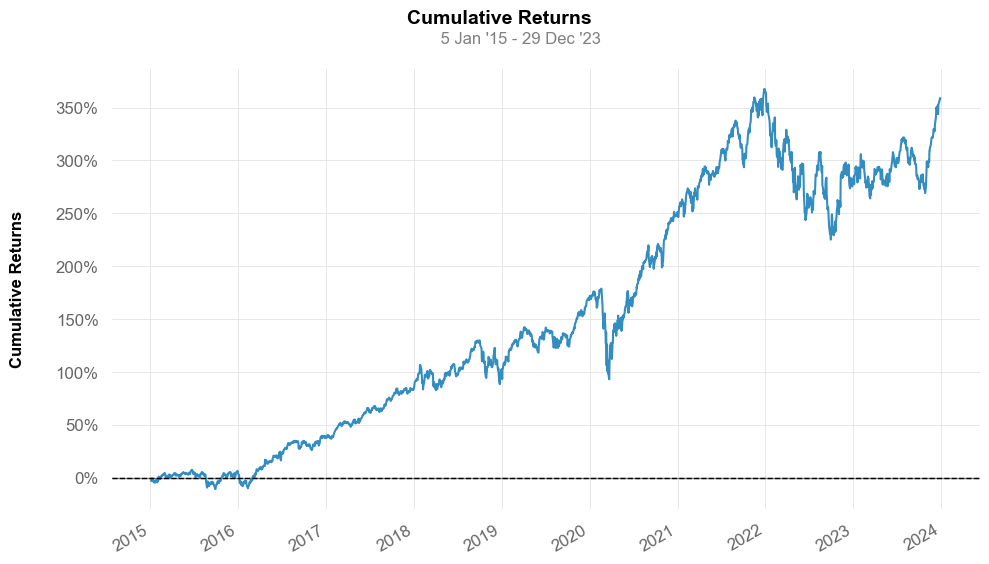

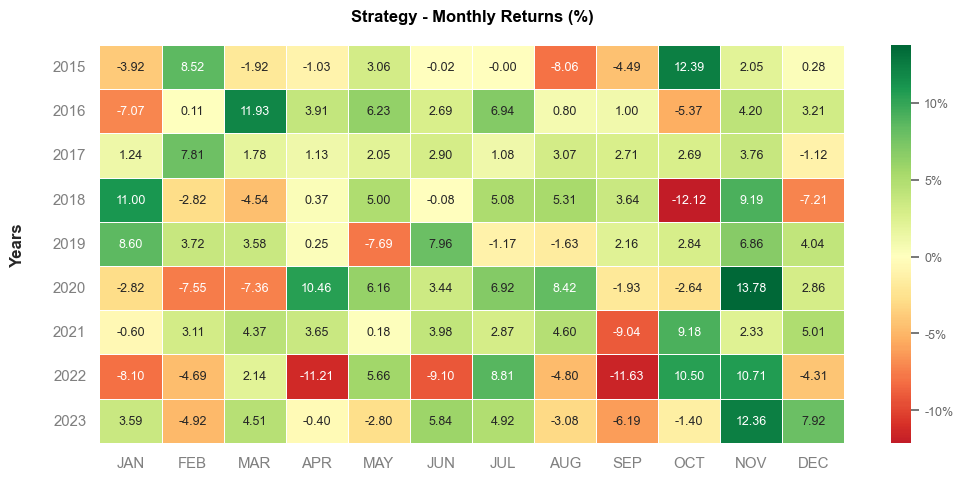

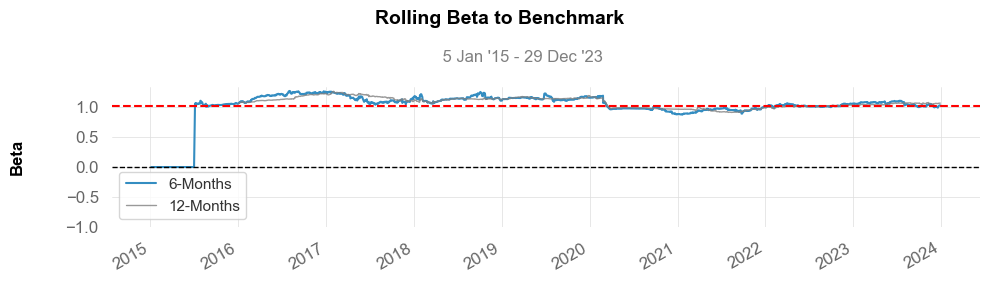

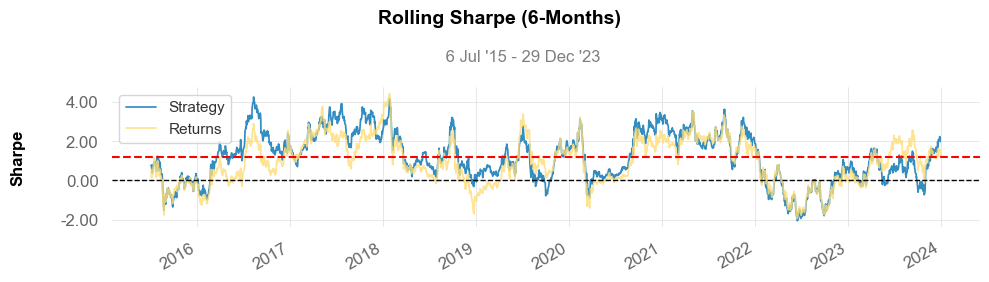

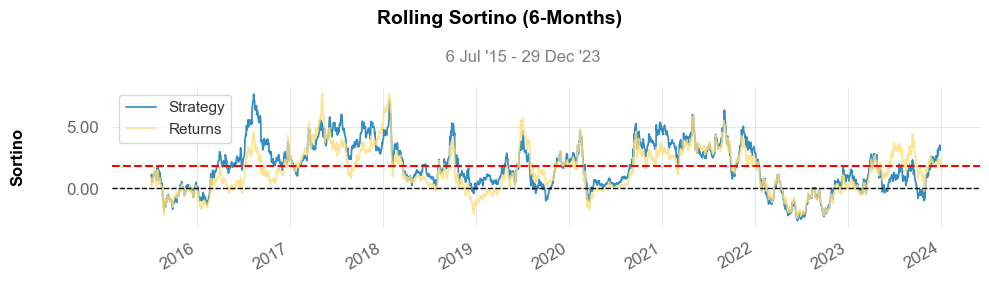

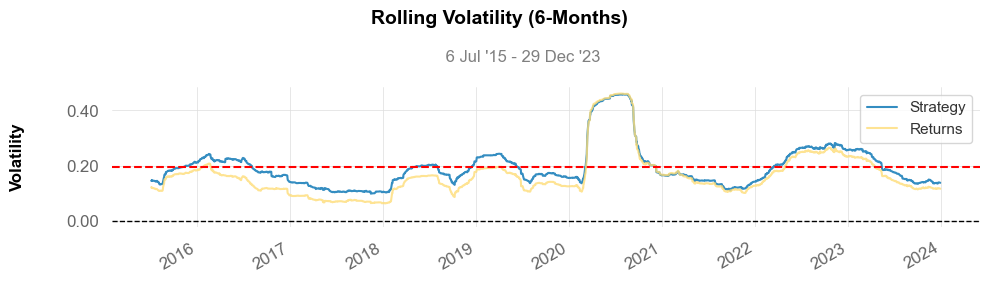

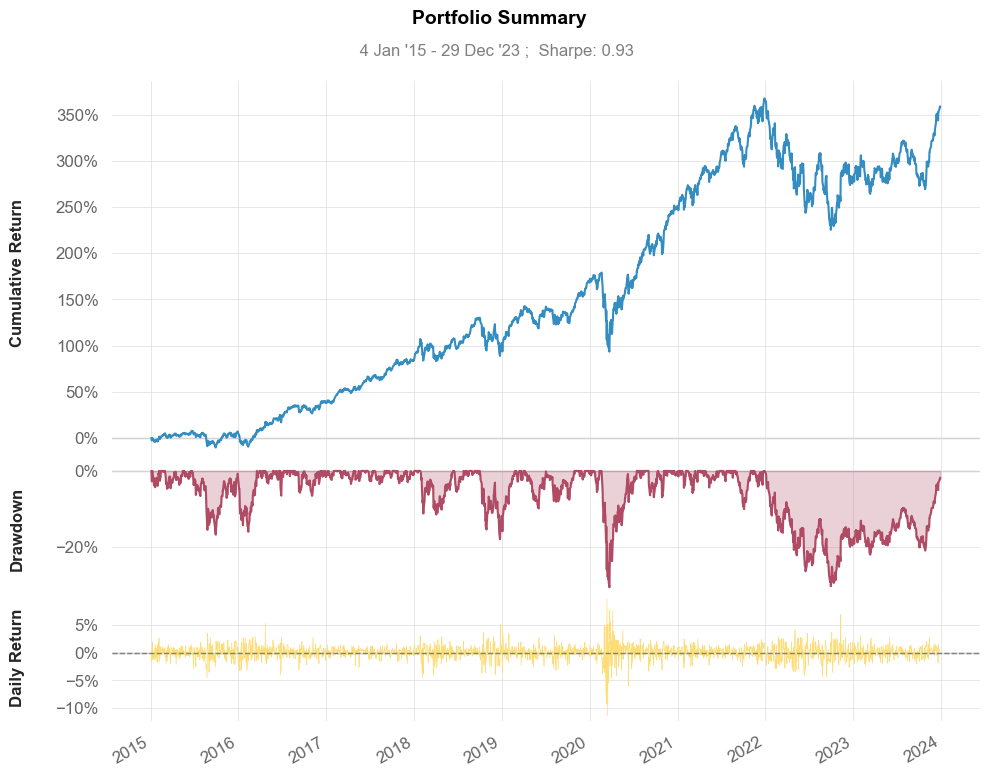

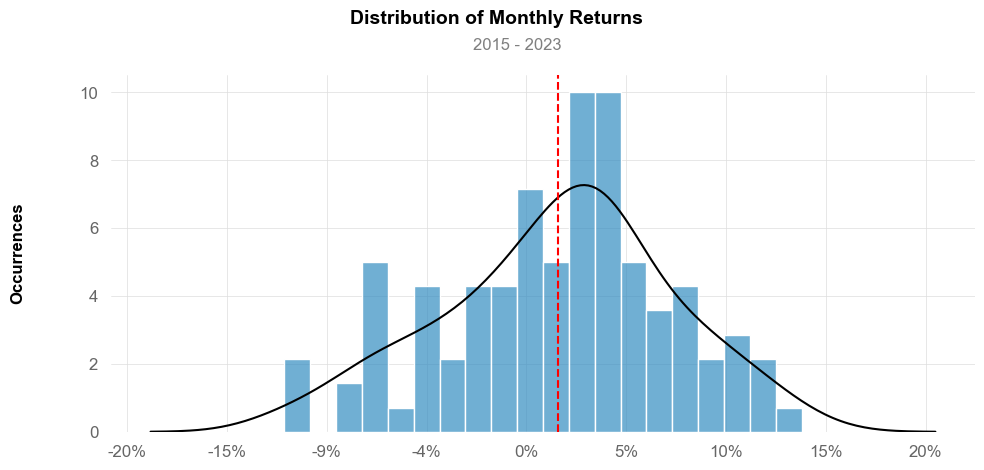

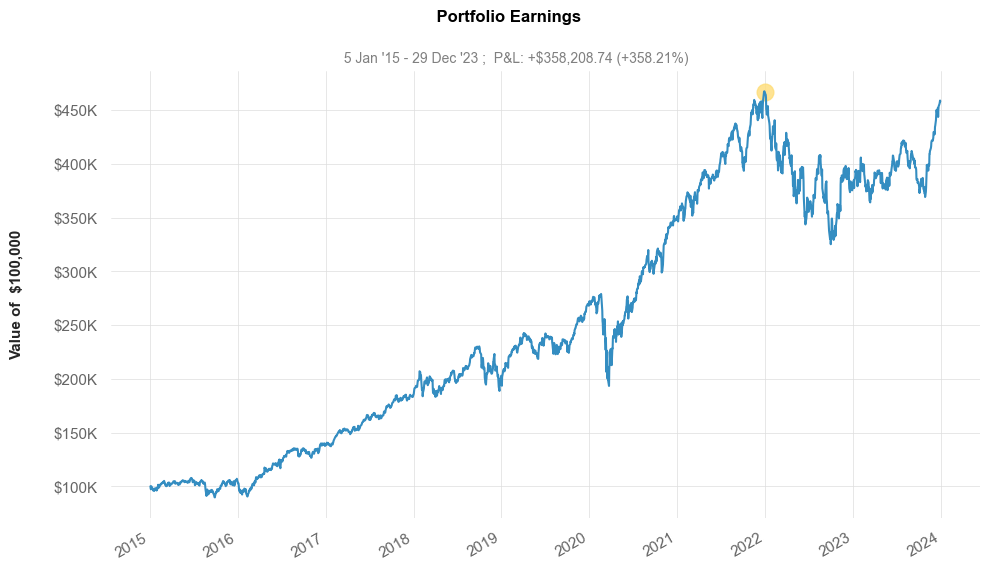

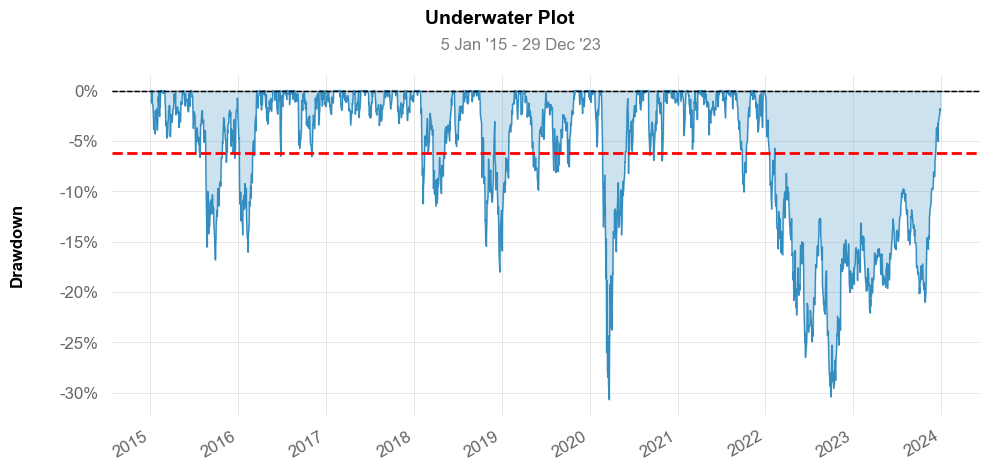

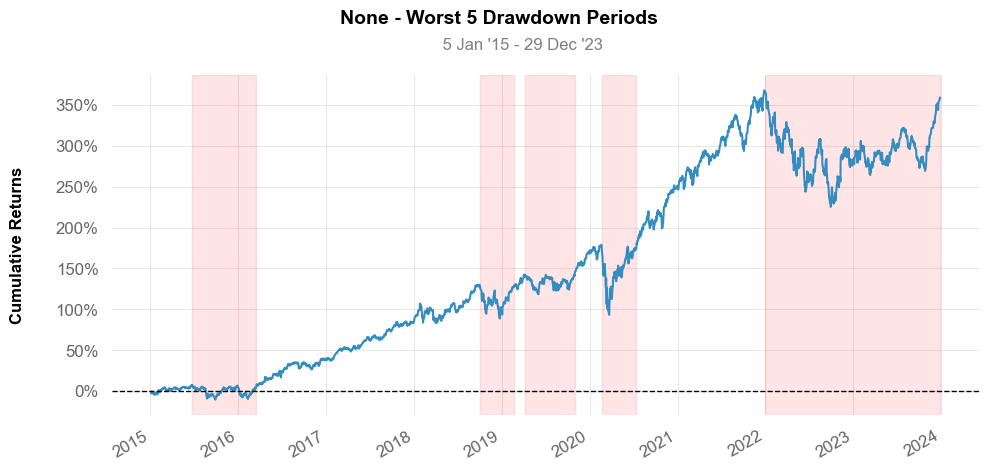

In [108]:
# Generate QuantStats Tearsheet
qs.extend_pandas()  # Extend pandas functionality with QuantStats
#qs.reports.full(portfolio_daily_returns, benchmark=sp500_daily_returns)

# Additional Plots
qs.plots.returns(portfolio_daily_returns)
qs.plots.monthly_returns(portfolio_daily_returns)
qs.plots.rolling_beta(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.rolling_sharpe(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.rolling_sortino(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.rolling_volatility(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.snapshot(portfolio_daily_returns)
qs.plots.histogram(portfolio_daily_returns)
qs.plots.earnings(portfolio_daily_returns)
qs.plots.drawdown(portfolio_daily_returns)
qs.plots.drawdowns_periods(portfolio_daily_returns)

Generating Pyfolio Tearsheet...


c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\pyfolio\plotting.py:670: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.471%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\pyfolio\plotting.py:1407: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\pyfolio\tears.py:1005: UserWarning:

Passed returns do not overlap with anyinteresting times.



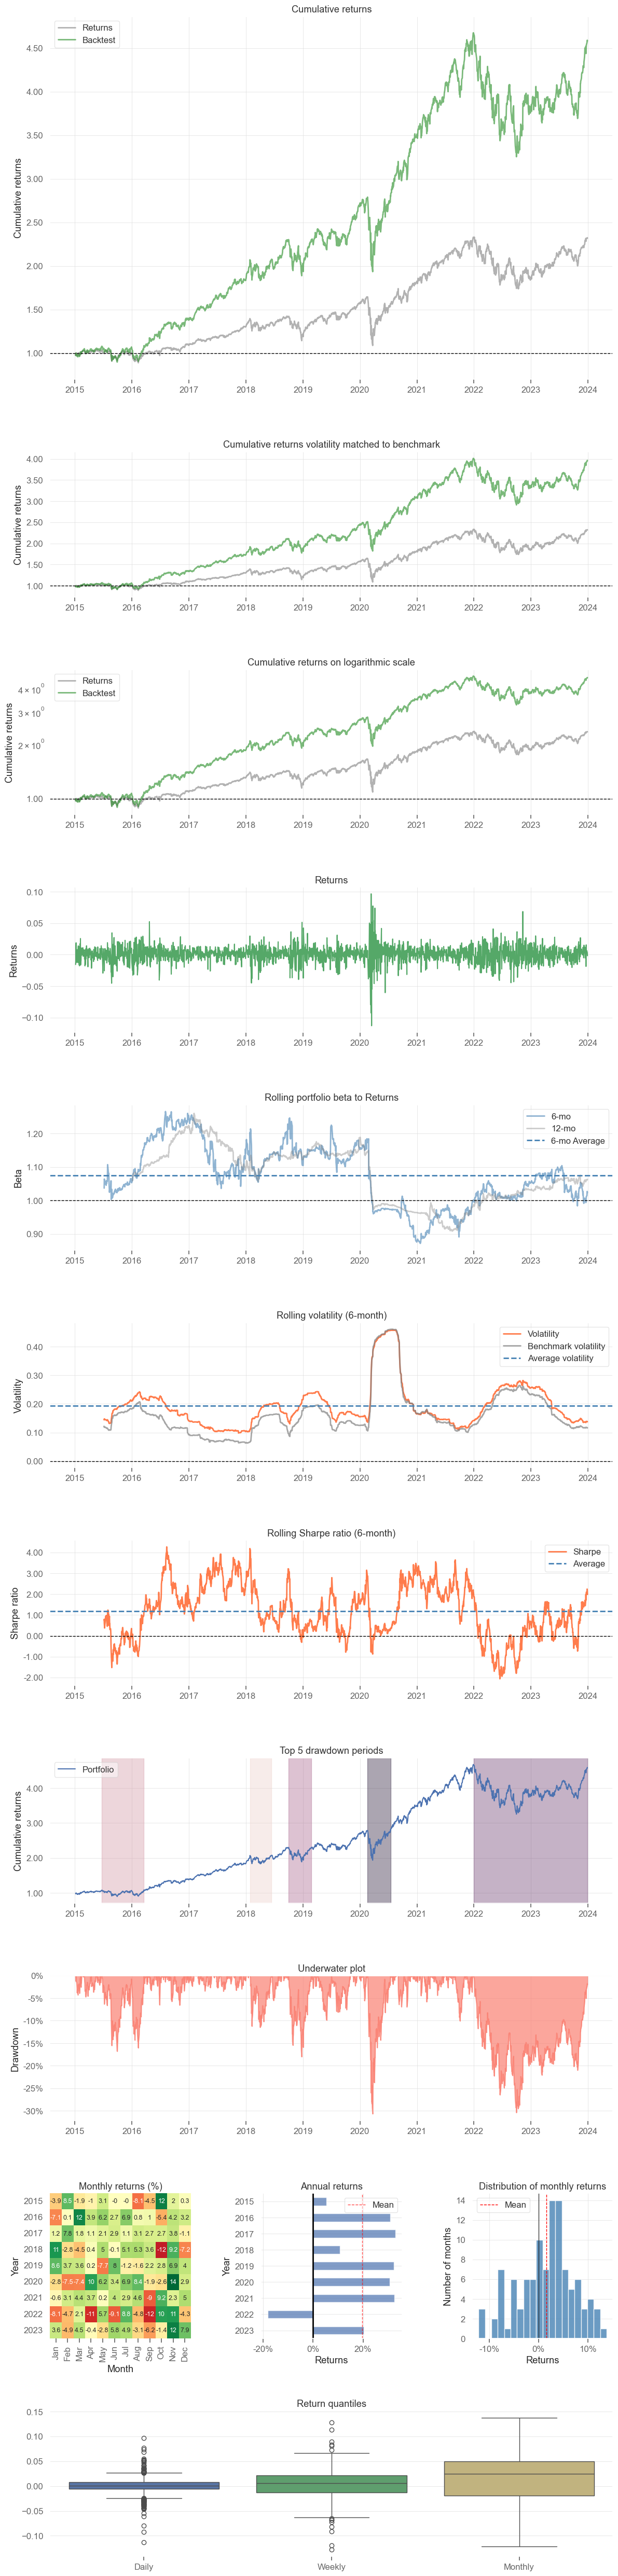

In [95]:
# Generate Tearsheets using Pyfolio
print("Generating Pyfolio Tearsheet...")
pf.create_full_tear_sheet(
    returns=portfolio_daily_returns,
    benchmark_rets=sp500_daily_returns,
    set_context=False
)

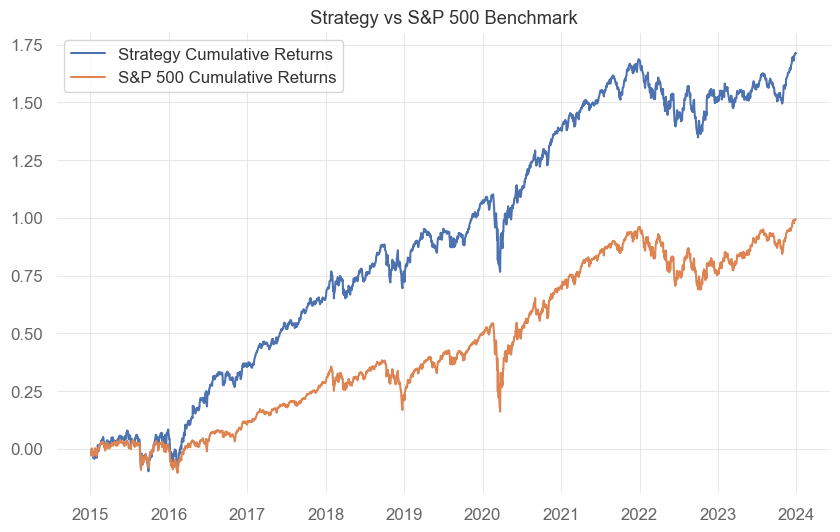

In [97]:
# Plot Cumulative Returns
plt.figure(figsize=(10, 6))
plt.plot(portfolio_daily_returns.cumsum(), label='Strategy Cumulative Returns')
plt.plot(sp500_daily_returns.cumsum(), label='S&P 500 Cumulative Returns')
plt.legend()
plt.title('Strategy vs S&P 500 Benchmark')
plt.show()

# XGBoost Model

In [133]:
# List to store SHAP values and feature importance for each split
all_shap_values = []
all_feature_importance = []
all_test_dfs = []

In [134]:
# Walk-forward validation loop for XGBoost
tscv = TimeSeriesSplit(n_splits=5)  # Adjust splits as needed

Split 1:


c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Classification Report for Split 1:
              precision    recall  f1-score   support

           0       0.46      0.55      0.50       342
           1       0.54      0.45      0.49       407

    accuracy                           0.50       749
   macro avg       0.50      0.50      0.50       749
weighted avg       0.50      0.50      0.49       749

Running SHAP analysis for Split 1...


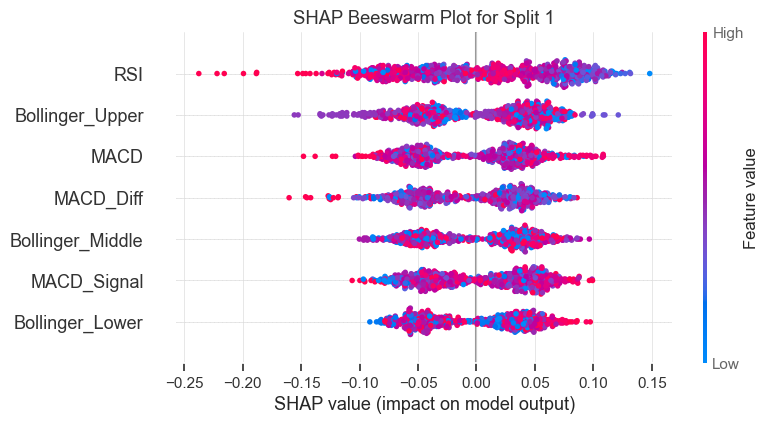

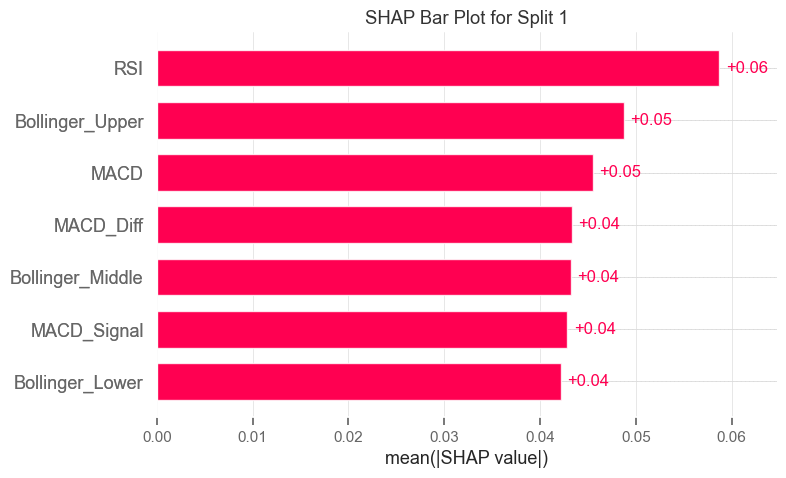

Split 2:


c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Classification Report for Split 2:
              precision    recall  f1-score   support

           0       0.47      0.66      0.55       341
           1       0.57      0.38      0.45       408

    accuracy                           0.51       749
   macro avg       0.52      0.52      0.50       749
weighted avg       0.52      0.51      0.50       749

Running SHAP analysis for Split 2...


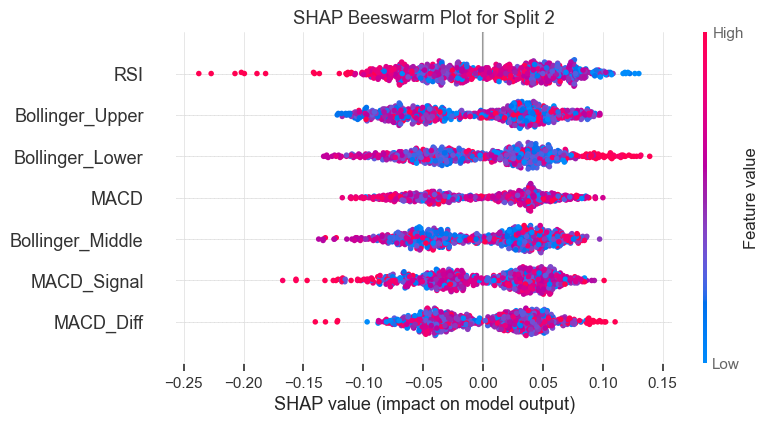

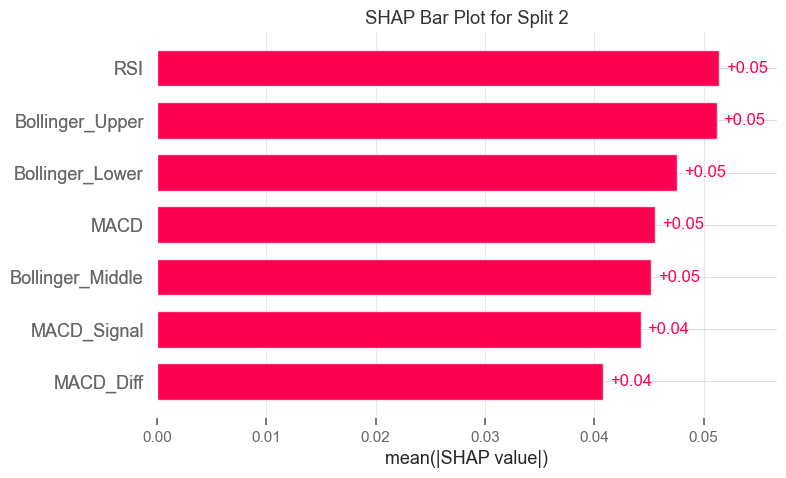

Split 3:


c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Classification Report for Split 3:
              precision    recall  f1-score   support

           0       0.48      0.36      0.41       328
           1       0.58      0.69      0.63       421

    accuracy                           0.55       749
   macro avg       0.53      0.53      0.52       749
weighted avg       0.53      0.55      0.53       749

Running SHAP analysis for Split 3...


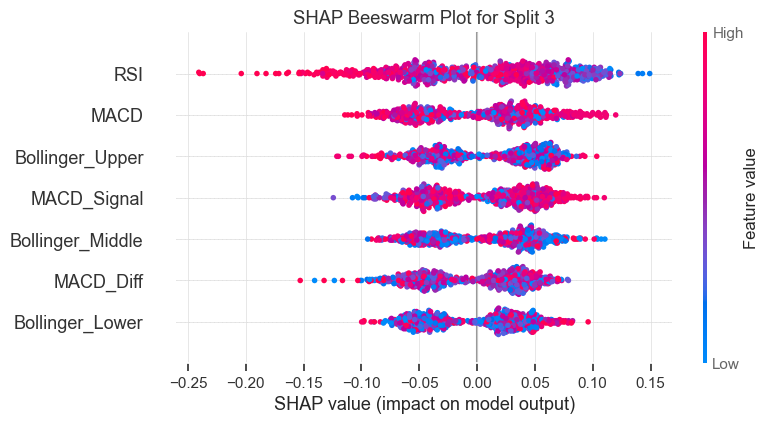

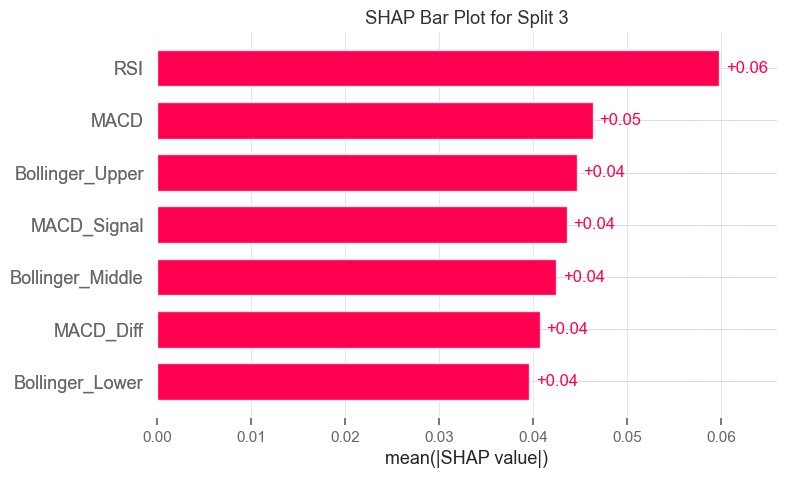

Split 4:


c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Classification Report for Split 4:
              precision    recall  f1-score   support

           0       0.49      0.38      0.43       359
           1       0.53      0.64      0.58       390

    accuracy                           0.52       749
   macro avg       0.51      0.51      0.50       749
weighted avg       0.51      0.52      0.51       749

Running SHAP analysis for Split 4...


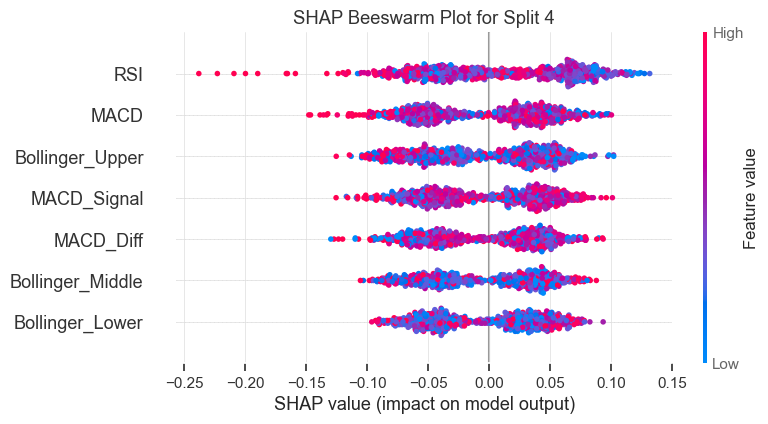

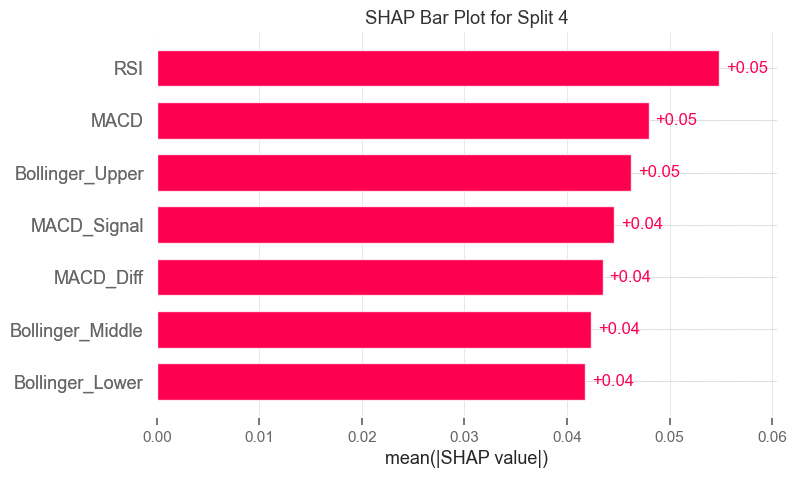

Split 5:


c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Classification Report for Split 5:
              precision    recall  f1-score   support

           0       0.46      0.45      0.45       379
           1       0.45      0.47      0.46       370

    accuracy                           0.46       749
   macro avg       0.46      0.46      0.46       749
weighted avg       0.46      0.46      0.46       749

Running SHAP analysis for Split 5...


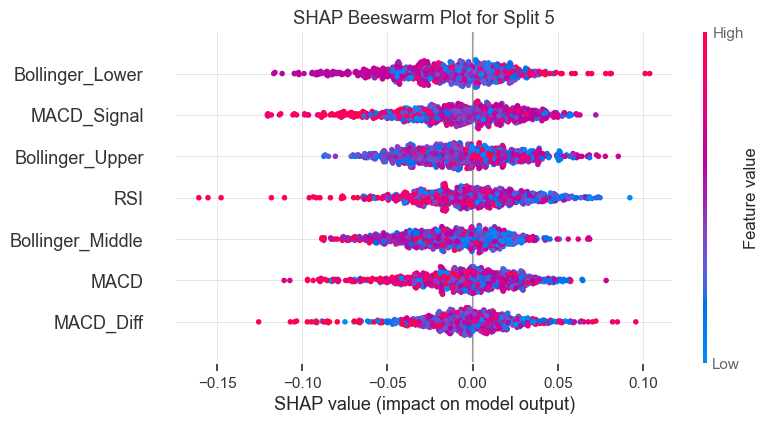

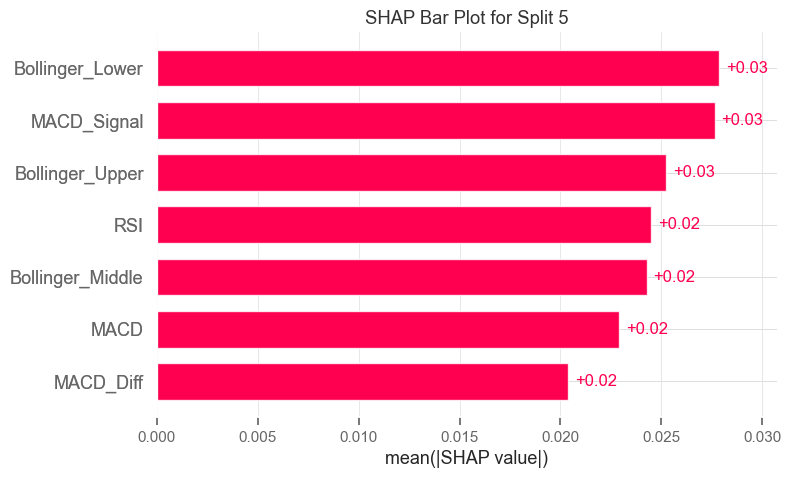

In [135]:
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Split {i + 1}:")
    
    # Split data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train XGBoost model
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
    xgb_model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    print(f"Classification Report for Split {i + 1}:")
    print(classification_report(y_test, y_pred))
    
    # Store predictions for backtesting
    stock_data.loc[X_test.index, f"Predicted_Signal_Split_{i + 1}"] = y_pred
    
    # SHAP Analysis
    print(f"Running SHAP analysis for Split {i + 1}...")
    explainer = shap.TreeExplainer(model)

    # For newer SHAP versions, shap_values can be shape (n_samples, n_features, n_classes)
    shap_values = explainer.shap_values(X_test)

    # Select the SHAP values for the positive class (class index 1)
    # This gives us a 2D array of shape (n_samples, n_features)
    if len(shap_values.shape) == 3:  # multi-class shape
        shap_values_class_1 = shap_values[:, :, 1]
    else:
        # For binary classifier with single set of shap values, just use shap_values directly
        shap_values_class_1 = shap_values

    # Handle base value for the positive class if explainer.expected_value is a list
    if isinstance(explainer.expected_value, list):
        base_value_class_1 = explainer.expected_value[1]
    else:
        base_value_class_1 = explainer.expected_value

    # Build a shap.Explanation object
    expl = shap.Explanation(
        values=shap_values_class_1,
        base_values=base_value_class_1,
        data=X_test,
        feature_names=X_test.columns
    )

 
    # Beeswarm plot
    shap.plots.beeswarm(expl, show=False)
    plt.title(f"SHAP Beeswarm Plot for Split {i + 1}")
    plt.show()

    # Bar plot (global feature importance)
    shap.plots.bar(expl, show=False)
    plt.title(f"SHAP Bar Plot for Split {i + 1}")
    plt.show()

    # Store SHAP values for global analysis
    all_shap_values.append(shap_values_class_1)
    all_feature_importance.append(np.mean(np.abs(shap_values_class_1), axis=0))  # Global importance

    all_test_dfs.append(X_test)

In [136]:
# Combine SHAP feature importance across splits
mean_feature_importance = np.mean(all_feature_importance, axis=0)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Importance': mean_feature_importance
}).sort_values(by='Mean Importance', ascending=False)

In [137]:
# Display aggregated feature importance
print("\nAggregated SHAP Feature Importance:")
print(importance_df)


Aggregated SHAP Feature Importance:
            Feature  Mean Importance
0               RSI         0.049852
4   Bollinger_Upper         0.043217
1              MACD         0.041663
2       MACD_Signal         0.040585
5   Bollinger_Lower         0.039807
6  Bollinger_Middle         0.039501
3         MACD_Diff         0.037744


combined_shap_values shape: (3745, 7)
X_all_test shape: (3745, 7)


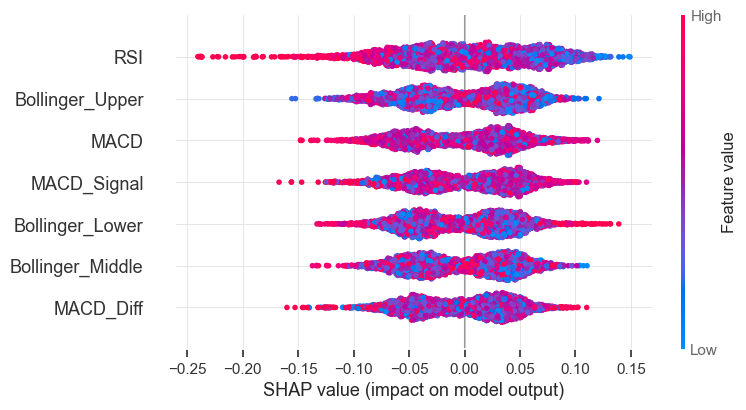

In [138]:
# Concatenate all SHAP values across splits
combined_shap_values = np.concatenate(all_shap_values, axis=0)

# Concatenate all test data in exactly the same order
X_all_test = pd.concat(all_test_dfs, axis=0)

# Confirm shapes match
print("combined_shap_values shape:", combined_shap_values.shape)
print("X_all_test shape:", X_all_test.shape)

# Plot global SHAP summary
shap.summary_plot(combined_shap_values, X_all_test)

In [123]:
# Combine predictions into a single column
stock_data["Predicted_Signal"] = stock_data[[f"Predicted_Signal_Split_{i + 1}" for i in range(tscv.n_splits)]].sum(axis=1)
stock_data["Predicted_Signal"] = stock_data["Predicted_Signal"].apply(lambda x: 1 if x > 0 else 0)

In [124]:
# Run the backtest
portfolio = backtest_strategy(stock_data)

In [125]:
# Performance Metrics
print("Portfolio Performance Metrics:")
print(f"Total Return: {portfolio.total_return():.2%}")
print(f"Annualized Return: {portfolio.annualized_return():.2%}")
print(f"Max Drawdown: {portfolio.max_drawdown():.2%}")
print(f"Sharpe Ratio: {portfolio.sharpe_ratio():.2f}")
print(f"Calmar Ratio: {portfolio.calmar_ratio():.2f}")

Portfolio Performance Metrics:
Total Return: 354.98%
Annualized Return: 27.67%
Max Drawdown: -42.30%
Sharpe Ratio: 0.94
Calmar Ratio: 0.65


In [127]:
# VectorBT Charts
portfolio.plot()  # Works for the entire portfolio
portfolio.drawdowns.plot()  # Drawdown analysis

# Ungroup trades to analyze each ticker separately
ungrouped_trades = portfolio.trades.regroup(group_by=False)

# Trade analysis for each ticker in the grouped portfolio
for ticker in portfolio.wrapper.columns:
    if ticker in ungrouped_trades.records_readable['Column'].unique():
        print(f"Plotting trades for {ticker}...")  # Debugging info
        # Select trades for the specific ticker
        trades_for_ticker = ungrouped_trades.select_one(column=ticker)
        fig = trades_for_ticker.plot()  # Get the figure for the plot
        fig.show()  # Explicitly show the figure

# Explicitly show all plots
plt.show()

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



Plotting trades for AFL...


Plotting trades for AOS...


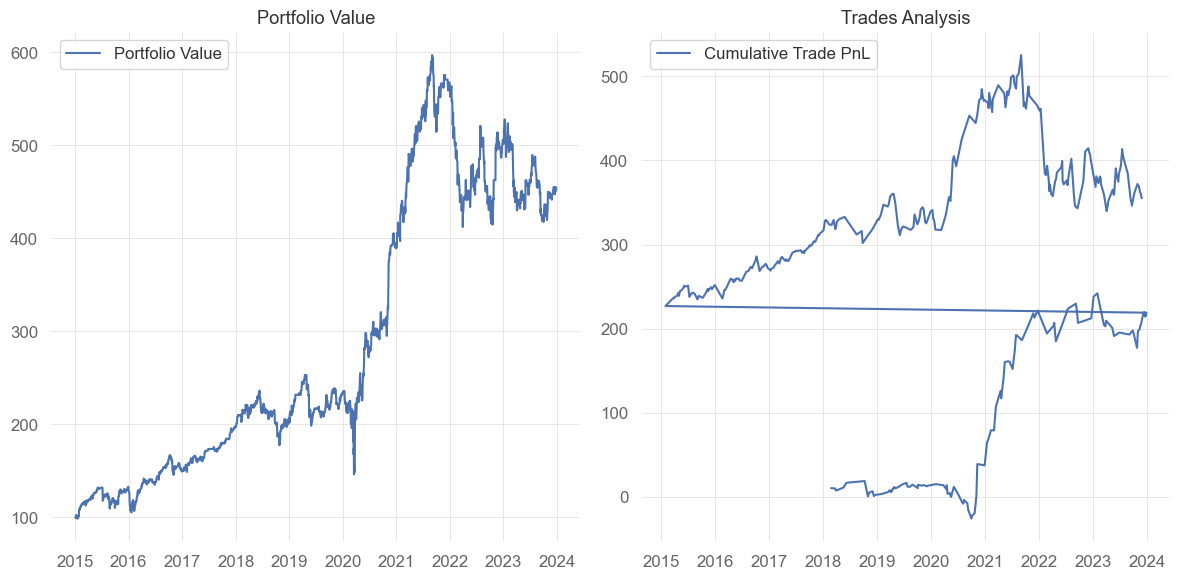

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'group',
              'showlegend': True,
              'type': 'scatter',
              'uid': '776db04b-94d2-4d66-a8d8-6fe3b36c46cd',
              'x': array([datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 5, 0, 0),
                          datetime.datetime(2015, 1, 6, 0, 0), ...,
                          datetime.datetime(2023, 12, 27, 0, 0),
                          datetime.datetime(2023, 12, 28, 0, 0),
                          datetime.datetime(2023, 12, 29, 0, 0)], dtype=object),
              'y': array([100.        , 100.        ,  99.18226975, ..., 451.72193777,
                          452.82489229, 454.97568306])},
             {'customdata': array([[19],
                                   [20],
                                   [57],
                                   [60],
                                   [93]], dtype=int64),
             

In [128]:
# Matplotlib figure for portfolio value and trades
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Portfolio value (Matplotlib)
axes[0].plot(portfolio.value().index, portfolio.value(), label="Portfolio Value")
axes[0].set_title("Portfolio Value")
axes[0].legend()

# Trades analysis (Matplotlib)
if not portfolio.trades.records_readable.empty:  # Check if trades data is available
    trades_pnl = portfolio.trades.records_readable['PnL'].cumsum()
    trades_pnl.index = pd.to_datetime(portfolio.trades.records_readable['Exit Timestamp'])  # Use timestamps for plotting
    axes[1].plot(trades_pnl.index, trades_pnl, label="Cumulative Trade PnL")
    axes[1].set_title("Trades Analysis")
    axes[1].legend()

plt.tight_layout()
plt.show()

# Plotly-based plots (VectorBT)
portfolio.plot()  # Entire portfolio
portfolio.drawdowns.plot(title="Drawdowns")

In [130]:
# Convert indices to datetime (if not already)
portfolio_daily_returns.index = pd.to_datetime(portfolio_daily_returns.index, errors='coerce')
sp500_daily_returns.index = pd.to_datetime(sp500_daily_returns.index, errors='coerce')

# Drop NaNs from invalid datetime conversions
portfolio_daily_returns = portfolio_daily_returns[portfolio_daily_returns.index.notna()]
sp500_daily_returns = sp500_daily_returns[sp500_daily_returns.index.notna()]

# Ensure both indices are sorted
portfolio_daily_returns = portfolio_daily_returns.sort_index()
sp500_daily_returns = sp500_daily_returns.sort_index()

# Align indices using intersection
aligned_index = portfolio_daily_returns.index.intersection(sp500_daily_returns.index)
portfolio_daily_returns = portfolio_daily_returns.loc[aligned_index]
sp500_daily_returns = sp500_daily_returns.loc[aligned_index]

# Drop remaining NaNs
portfolio_daily_returns = portfolio_daily_returns.dropna()
sp500_daily_returns = sp500_daily_returns.dropna()

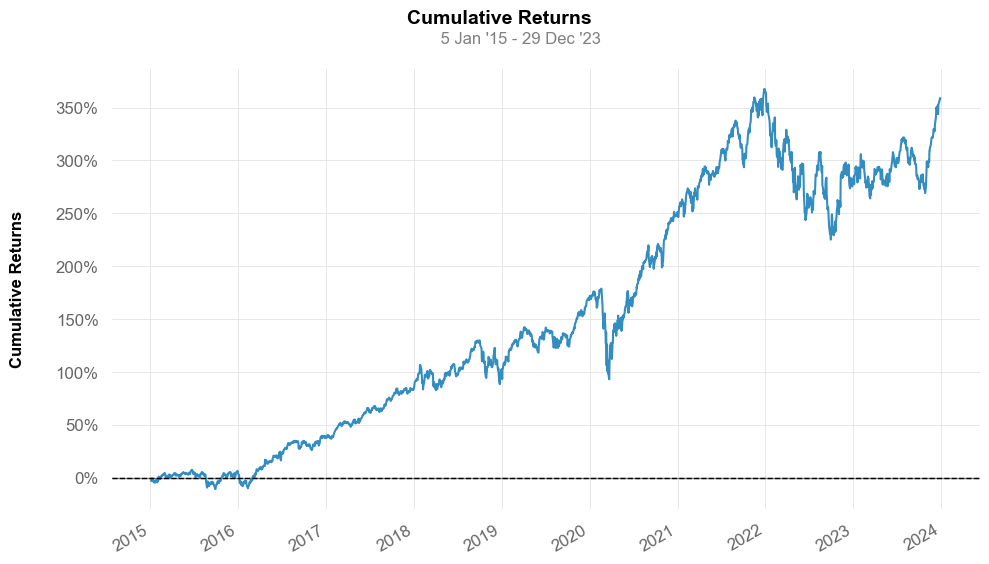

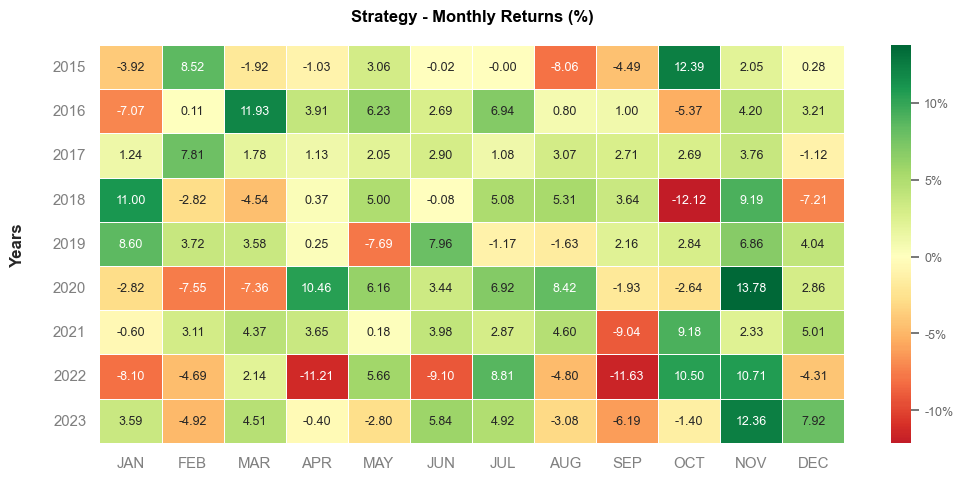

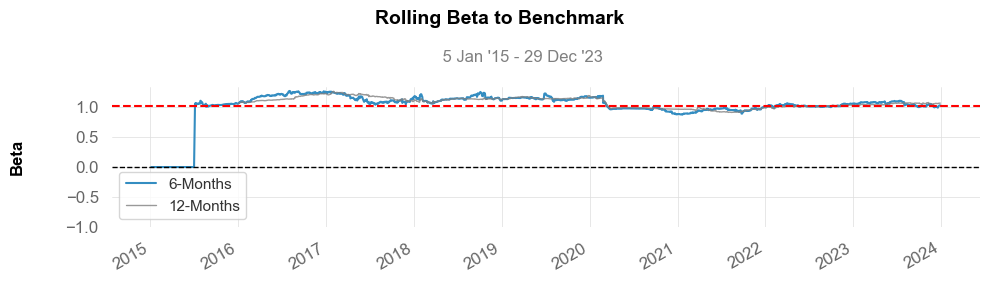

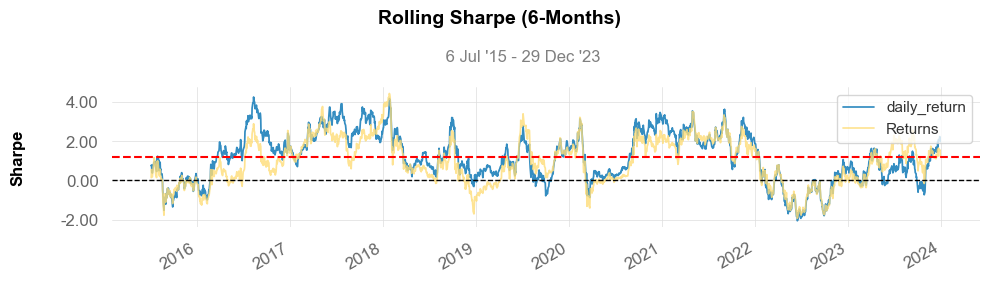

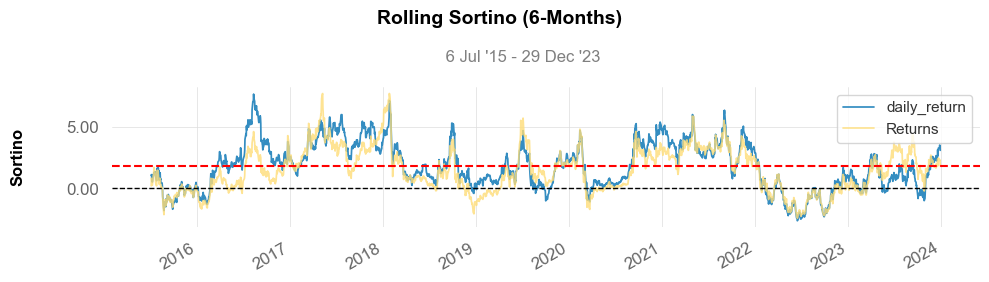

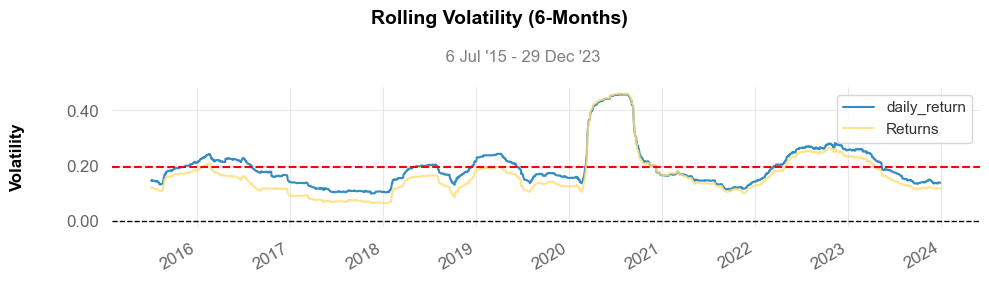

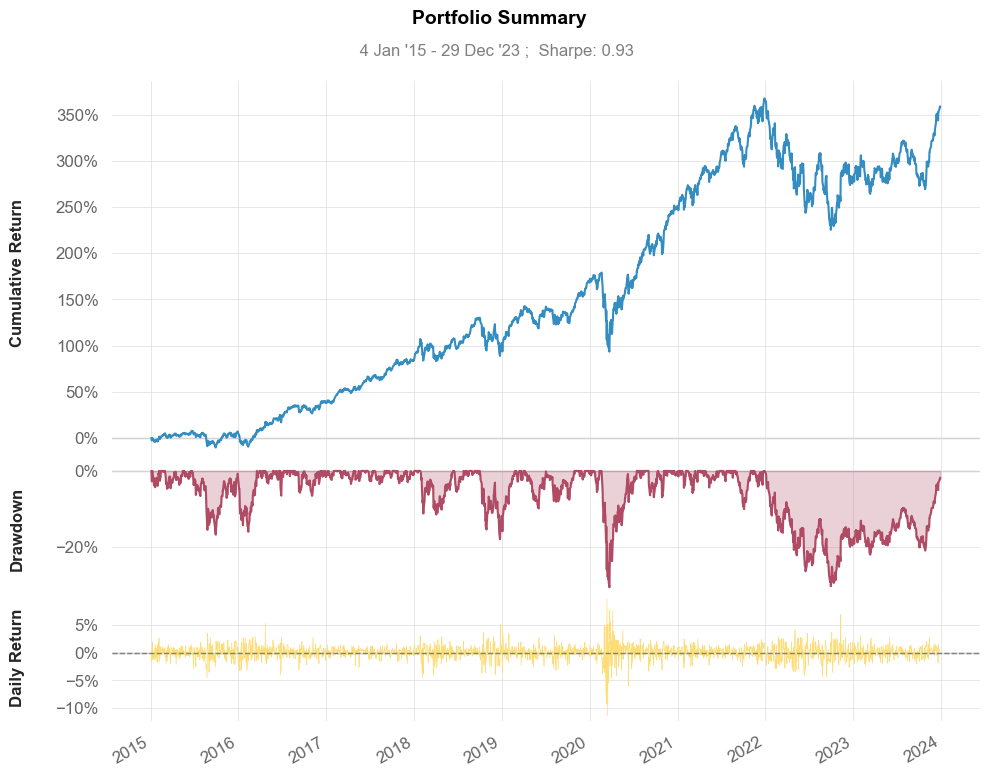

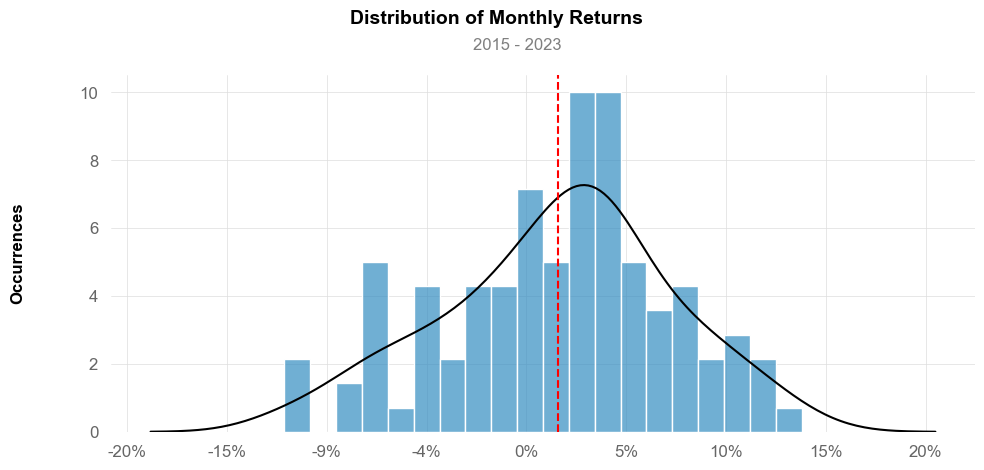

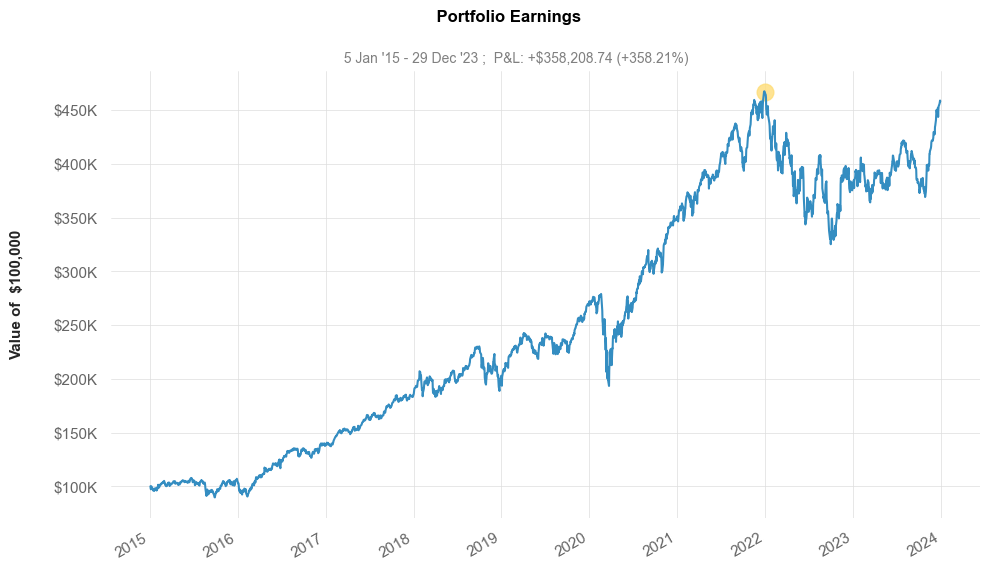

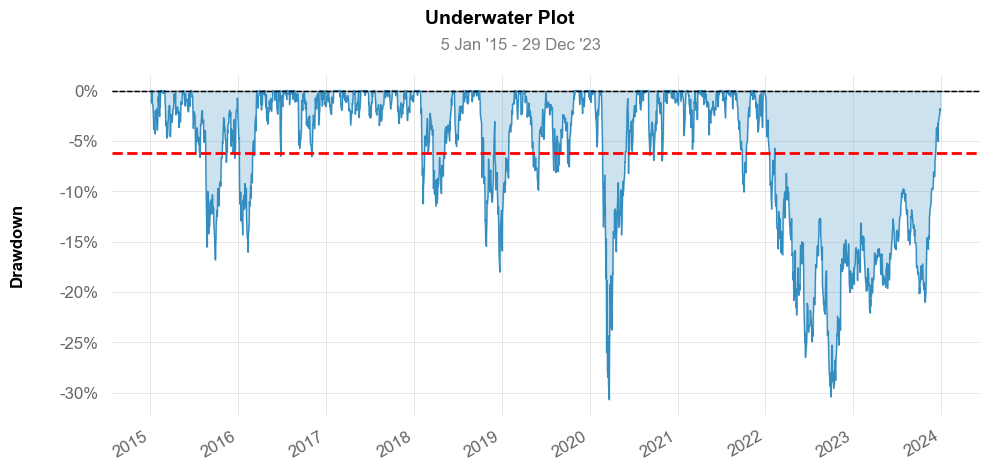

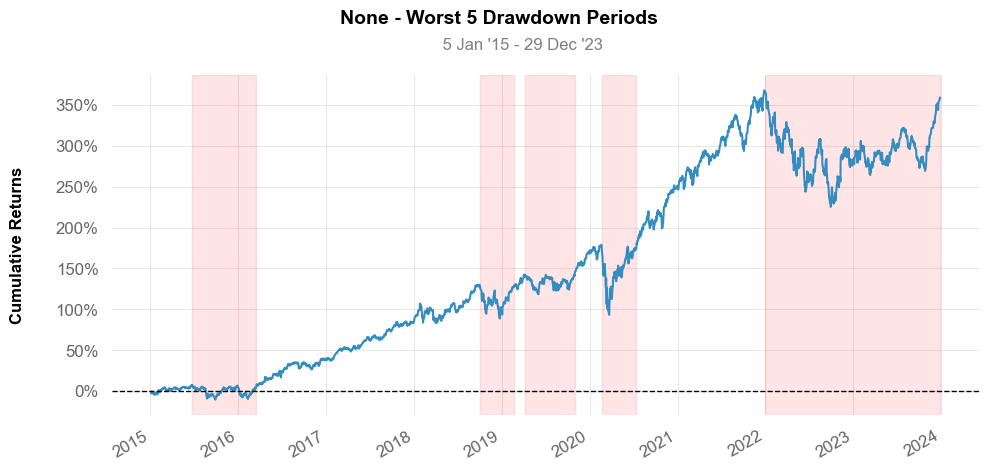

In [131]:
# Generate QuantStats Tearsheet
qs.extend_pandas()  # Extend pandas functionality with QuantStats
#qs.reports.full(portfolio_daily_returns, benchmark=sp500_daily_returns)

# Additional Plots
qs.plots.returns(portfolio_daily_returns)
qs.plots.monthly_returns(portfolio_daily_returns)
qs.plots.rolling_beta(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.rolling_sharpe(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.rolling_sortino(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.rolling_volatility(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.snapshot(portfolio_daily_returns)
qs.plots.histogram(portfolio_daily_returns)
qs.plots.earnings(portfolio_daily_returns)
qs.plots.drawdown(portfolio_daily_returns)
qs.plots.drawdowns_periods(portfolio_daily_returns)

Generating Pyfolio Tearsheet...


c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\pyfolio\plotting.py:670: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18.471%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\pyfolio\plotting.py:1407: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\pyfolio\tears.py:1005: UserWarning:

Passed returns do not overlap with anyinteresting times.



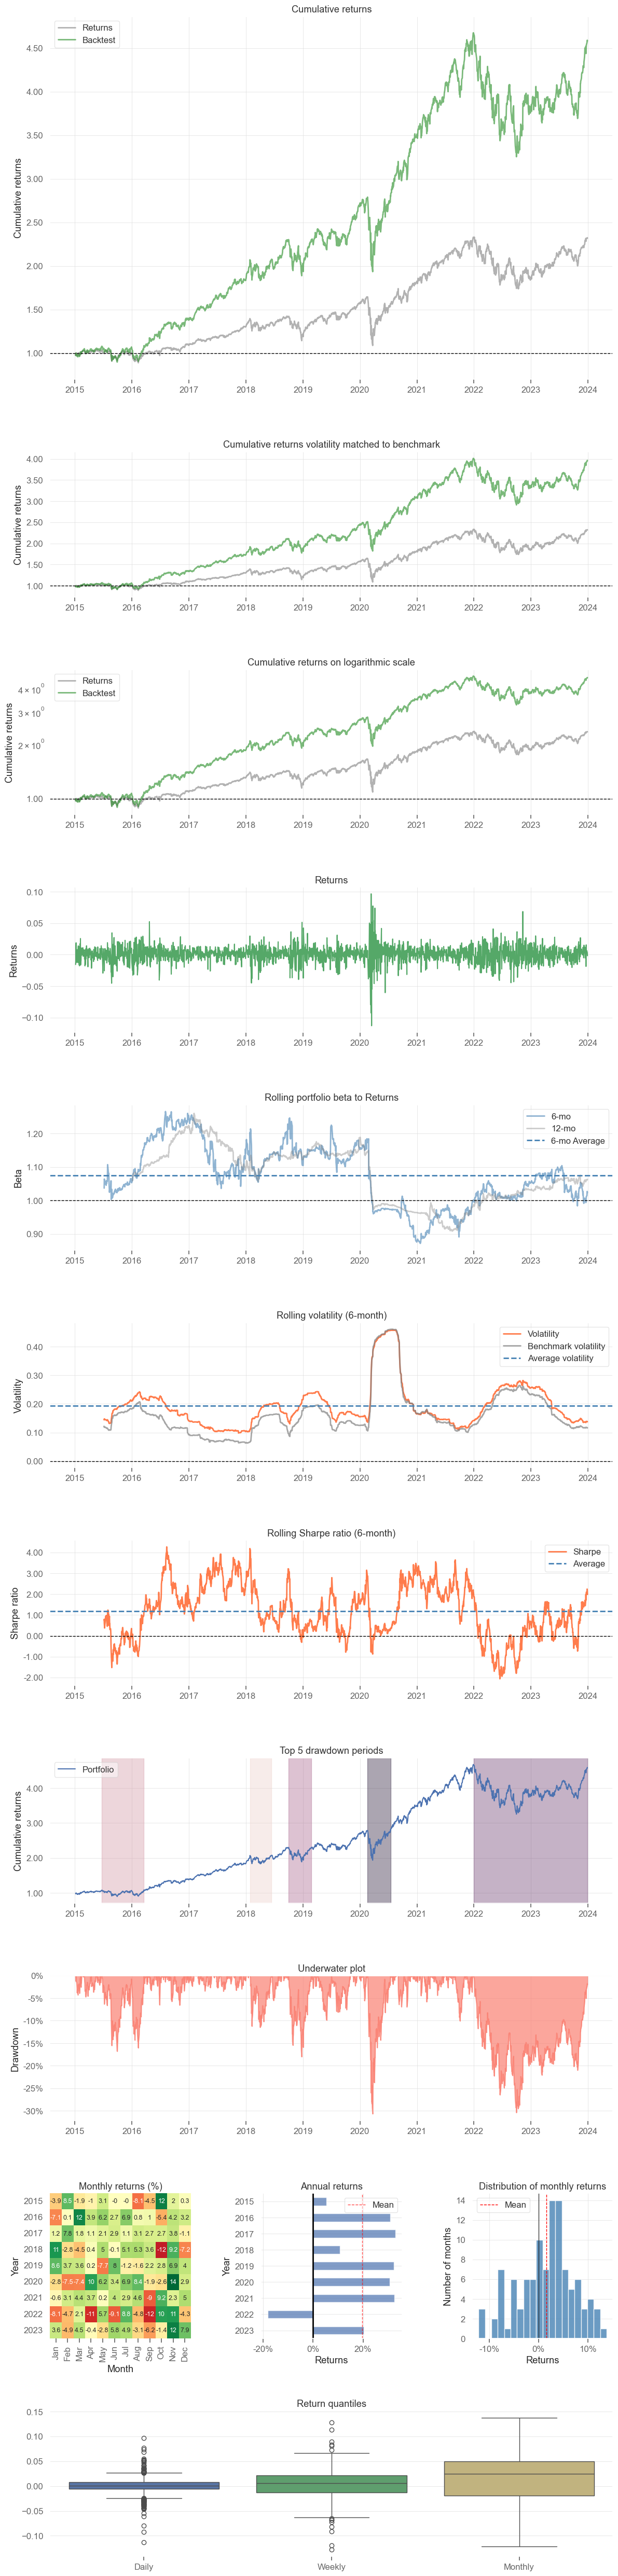

In [132]:
# Generate Tearsheets using Pyfolio
print("Generating Pyfolio Tearsheet...")
pf.create_full_tear_sheet(
    returns=portfolio_daily_returns,
    benchmark_rets=sp500_daily_returns,
    set_context=False
)

# LSTM

In [153]:
def create_sequences(X, y, sequence_length=50):

    # Convert X, y to NumPy arrays if they're DataFrame/Series
    X_array = X.to_numpy() if not isinstance(X, np.ndarray) else X
    y_array = y.to_numpy() if not isinstance(y, np.ndarray) else y
    
    X_seq, y_seq, idx_seq = [], [], []
    
    for i in range(len(X_array) - sequence_length):
        X_seq.append(X_array[i : i + sequence_length])
        y_seq.append(y_array[i + sequence_length])
        
        # Store the integer row index for reference
        idx_seq.append(i + sequence_length)
        
    return np.array(X_seq), np.array(y_seq), np.array(idx_seq)

In [154]:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)  # shape: (n_samples, n_features)

sequence_length = 50
X_seq, y_seq, idx_seq = create_sequences(scaled_X, y, sequence_length=sequence_length)

print("X_seq shape:", X_seq.shape)  # (num_sequences, 50, n_features)
print("y_seq shape:", y_seq.shape)  # (num_sequences,)
print("idx_seq shape:", idx_seq.shape)

X_seq shape: (4445, 50, 7)
y_seq shape: (4445,)
idx_seq shape: (4445,)


In [155]:
# Prepare the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [156]:
for i, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"Split {i+1}:")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]
    idx_test_fold = idx_seq[test_index]  # Real indices
    
    # Build LSTM
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    
    # Predict
    y_pred = (lstm_model.predict(X_test) > 0.5).astype(int)
    print(f"Classification Report for Split {i+1}:")
    print(classification_report(y_test, y_pred))
    
    # Store predictions in stock_data using the real row labels
    stock_data.loc[idx_test_fold, f"Predicted_Signal_Split_{i+1}"] = y_pred.flatten()

Split 1:


c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.5443 - loss: 0.6950 - val_accuracy: 0.5432 - val_loss: 0.6918
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5692 - loss: 0.6877 - val_accuracy: 0.5514 - val_loss: 0.6886
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.5235 - loss: 0.6904 - val_accuracy: 0.5514 - val_loss: 0.6881
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5658 - loss: 0.6854 - val_accuracy: 0.5514 - val_loss: 0.6881
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5502 - loss: 0.6889 - val_accuracy: 0.5514 - val_loss: 0.6880
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5768 - loss: 0.6853 - val_accuracy: 0.5514 - val_loss: 0.6885
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5601 - loss: 0.6897 - val_accuracy: 0.5514 - val_loss: 0.6881
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5282 - loss: 0.6925 - val_accuracy: 0.5514 -

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.5429 - loss: 0.6912 - val_accuracy: 0.5446 - val_loss: 0.6939
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5016 - loss: 0.6987 - val_accuracy: 0.5446 - val_loss: 0.6898
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5708 - loss: 0.6867 - val_accuracy: 0.5446 - val_loss: 0.6896
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5372 - loss: 0.6899 - val_accuracy: 0.5446 - val_loss: 0.6902
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5499 - loss: 0.6915 - val_accuracy: 0.5446 - val_loss: 0.6894
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5713 - loss: 0.6851 - val_accuracy: 0.5446 - val_loss: 0.6911
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5496 - loss: 0.6903 - val_accuracy: 0.5446 - val_loss: 0.6901
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5581 - loss: 0.6893 - val_accuracy: 0.5446 - 

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.5226 - loss: 0.6942 - val_accuracy: 0.5581 - val_loss: 0.6881
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5292 - loss: 0.6970 - val_accuracy: 0.5581 - val_loss: 0.6864
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5457 - loss: 0.6890 - val_accuracy: 0.5581 - val_loss: 0.6877
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5273 - loss: 0.6917 - val_accuracy: 0.5581 - val_loss: 0.6888
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5397 - loss: 0.6941 - val_accuracy: 0.5581 - val_loss: 0.6875
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5525 - loss: 0.6880 - val_accuracy: 0.5581 - val_loss: 0.6866
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5415 - loss: 0.6907 - val_accuracy: 0.5581 - val_loss: 0.6864
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5388 - loss: 0.6915 - val_accuracy: 0.5581 - 

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.5475 - loss: 0.6919 - val_accuracy: 0.5203 - val_loss: 0.6925
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.5526 - loss: 0.6892 - val_accuracy: 0.5203 - val_loss: 0.6952
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 0.5520 - loss: 0.6895 - val_accuracy: 0.5203 - val_loss: 0.6933
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.5398 - loss: 0.6905 - val_accuracy: 0.5203 - val_loss: 0.6947
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.5514 - loss: 0.6881 - val_accuracy: 0.5203 - val_loss: 0.6925
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.5362 - loss: 0.6898 - val_accuracy: 0.5203 - val_loss: 0.6929
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.5549 - loss: 0.6888 - val_accuracy: 0.5203 - val_loss: 0.6928
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.5329 - loss: 0.6912 - val_accu

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input

Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.5285 - loss: 0.6929 - val_accuracy: 0.4932 - val_loss: 0.6978
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.5274 - loss: 0.6930 - val_accuracy: 0.4932 - val_loss: 0.7003
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.5344 - loss: 0.6923 - val_accuracy: 0.4932 - val_loss: 0.7014
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.5402 - loss: 0.6913 - val_accuracy: 0.4932 - val_loss: 0.6984
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.5490 - loss: 0.6886 - val_accuracy: 0.4932 - val_loss: 0.6962
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.5332 - loss: 0.6917 - val_accuracy: 0.4932 - val_loss: 0.7045
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.5563 - loss: 0.6868 - val_accuracy: 0.4932 - val_loss: 0.6943
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.5476 - loss: 0

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [157]:
# Combine predictions into a single column
stock_data["Predicted_Signal"] = stock_data[[f"Predicted_Signal_Split_{i + 1}" for i in range(tscv.n_splits)]].sum(axis=1)
stock_data["Predicted_Signal"] = stock_data["Predicted_Signal"].apply(lambda x: 1 if x > 0 else 0)

In [158]:
# Run the backtest
portfolio = backtest_strategy(stock_data)

In [159]:
# Performance Metrics
print("Portfolio Performance Metrics:")
print(f"Total Return: {portfolio.total_return():.2%}")
print(f"Annualized Return: {portfolio.annualized_return():.2%}")
print(f"Max Drawdown: {portfolio.max_drawdown():.2%}")
print(f"Sharpe Ratio: {portfolio.sharpe_ratio():.2f}")
print(f"Calmar Ratio: {portfolio.calmar_ratio():.2f}")

Portfolio Performance Metrics:
Total Return: 209.04%
Annualized Return: 19.95%
Max Drawdown: -48.78%
Sharpe Ratio: 0.71
Calmar Ratio: 0.41


In [160]:
# VectorBT Charts
portfolio.plot()  # Works for the entire portfolio
portfolio.drawdowns.plot()  # Drawdown analysis

# Ungroup trades to analyze each ticker separately
ungrouped_trades = portfolio.trades.regroup(group_by=False)

# Trade analysis for each ticker in the grouped portfolio
for ticker in portfolio.wrapper.columns:
    if ticker in ungrouped_trades.records_readable['Column'].unique():
        print(f"Plotting trades for {ticker}...")  # Debugging info
        # Select trades for the specific ticker
        trades_for_ticker = ungrouped_trades.select_one(column=ticker)
        fig = trades_for_ticker.plot()  # Get the figure for the plot
        fig.show()  # Explicitly show the figure

# Explicitly show all plots
plt.show()

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



Plotting trades for AOS...


Plotting trades for MMM...


In [167]:
# Use portfolio daily returns and S&P 500 daily returns
portfolio_daily_returns = portfolio.daily_returns()
benchmark_daily_returns = sp500_daily_returns  # Pre-calculated S&P 500 returns

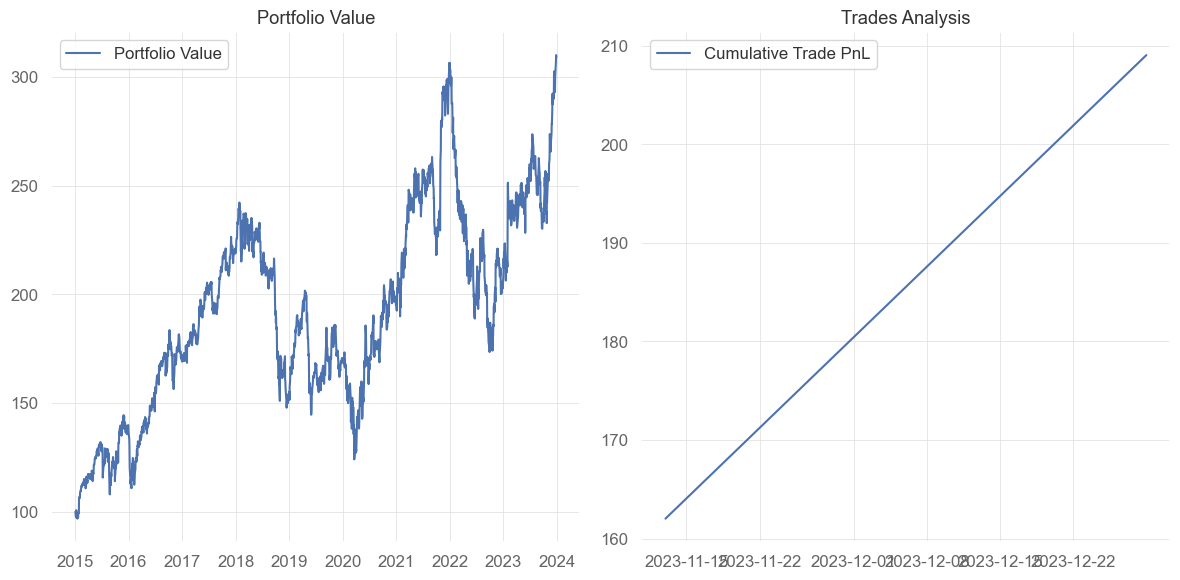

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\vectorbt\generic\plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



FigureWidget({
    'data': [{'line': {'color': '#1f77b4'},
              'name': 'group',
              'showlegend': True,
              'type': 'scatter',
              'uid': '042fc4e6-9f76-40b9-a474-6875da931ef5',
              'x': array([datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 5, 0, 0),
                          datetime.datetime(2015, 1, 6, 0, 0), ...,
                          datetime.datetime(2023, 12, 27, 0, 0),
                          datetime.datetime(2023, 12, 28, 0, 0),
                          datetime.datetime(2023, 12, 29, 0, 0)], dtype=object),
              'y': array([100.        ,  98.25031321,  97.44689067, ..., 307.39625165,
                          310.08181536, 309.03584023])},
             {'customdata': array([[19],
                                   [24],
                                   [61],
                                   [68],
                                   [78]], dtype=int64),
             

In [162]:
# Matplotlib figure for portfolio value and trades
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Portfolio value (Matplotlib)
axes[0].plot(portfolio.value().index, portfolio.value(), label="Portfolio Value")
axes[0].set_title("Portfolio Value")
axes[0].legend()

# Trades analysis (Matplotlib)
if not portfolio.trades.records_readable.empty:  # Check if trades data is available
    trades_pnl = portfolio.trades.records_readable['PnL'].cumsum()
    trades_pnl.index = pd.to_datetime(portfolio.trades.records_readable['Exit Timestamp'])  # Use timestamps for plotting
    axes[1].plot(trades_pnl.index, trades_pnl, label="Cumulative Trade PnL")
    axes[1].set_title("Trades Analysis")
    axes[1].legend()

plt.tight_layout()
plt.show()

# Plotly-based plots (VectorBT)
portfolio.plot()  # Entire portfolio
portfolio.drawdowns.plot(title="Drawdowns")

In [168]:
# Convert indices to datetime (if not already)
portfolio_daily_returns.index = pd.to_datetime(portfolio_daily_returns.index, errors='coerce')
sp500_daily_returns.index = pd.to_datetime(sp500_daily_returns.index, errors='coerce')

# Drop NaNs from invalid datetime conversions
portfolio_daily_returns = portfolio_daily_returns[portfolio_daily_returns.index.notna()]
sp500_daily_returns = sp500_daily_returns[sp500_daily_returns.index.notna()]

# Ensure both indices are sorted
portfolio_daily_returns = portfolio_daily_returns.sort_index()
sp500_daily_returns = sp500_daily_returns.sort_index()

# Align indices using intersection
aligned_index = portfolio_daily_returns.index.intersection(sp500_daily_returns.index)
portfolio_daily_returns = portfolio_daily_returns.loc[aligned_index]
sp500_daily_returns = sp500_daily_returns.loc[aligned_index]

# Drop remaining NaNs
portfolio_daily_returns = portfolio_daily_returns.dropna()
sp500_daily_returns = sp500_daily_returns.dropna()

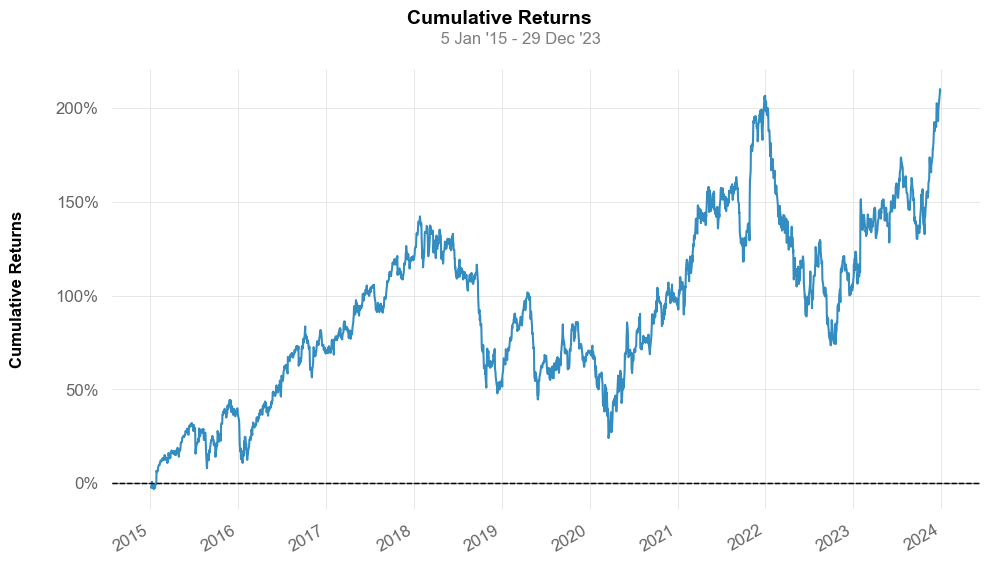

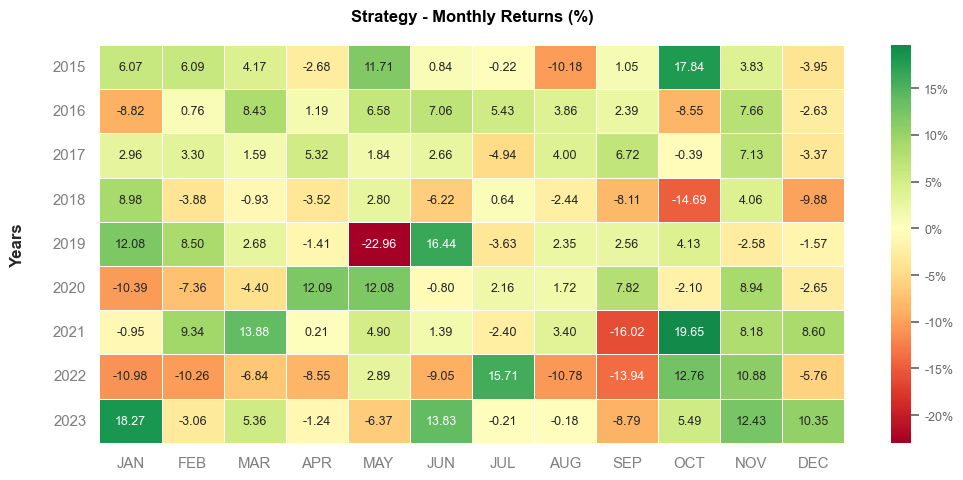

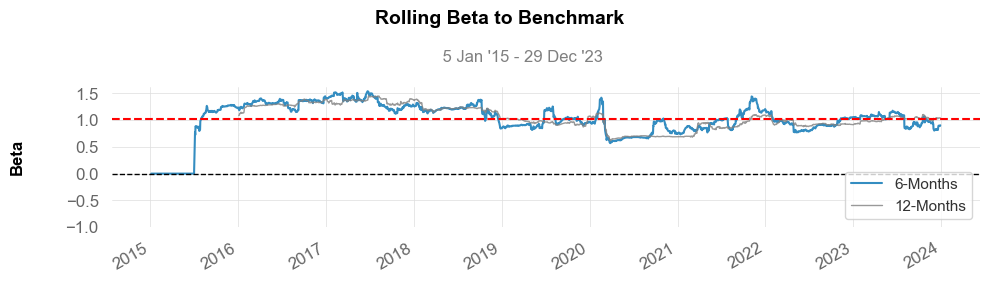

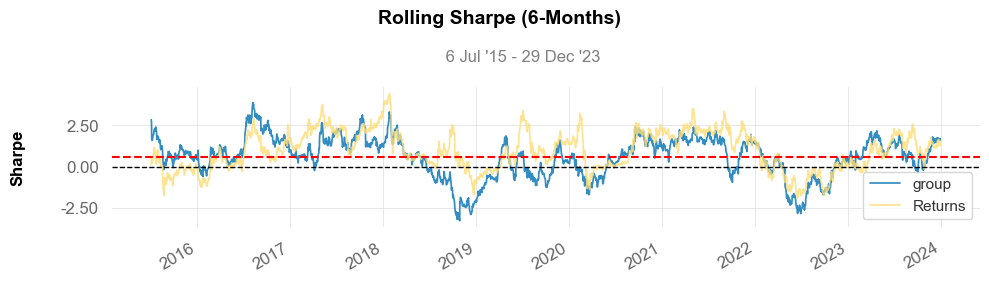

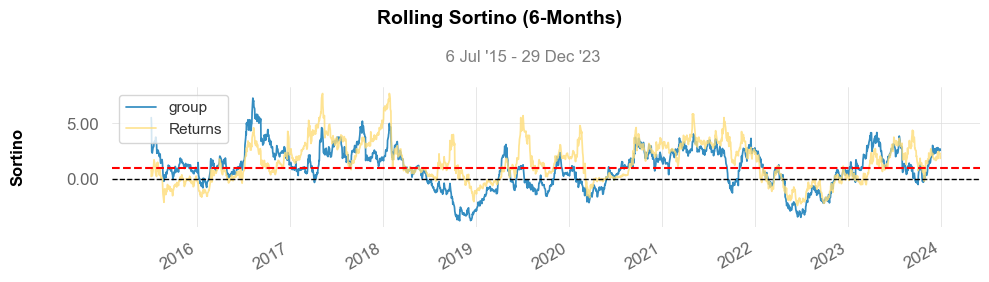

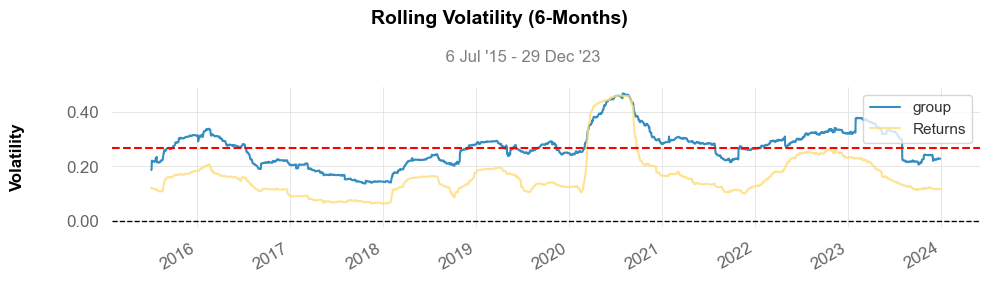

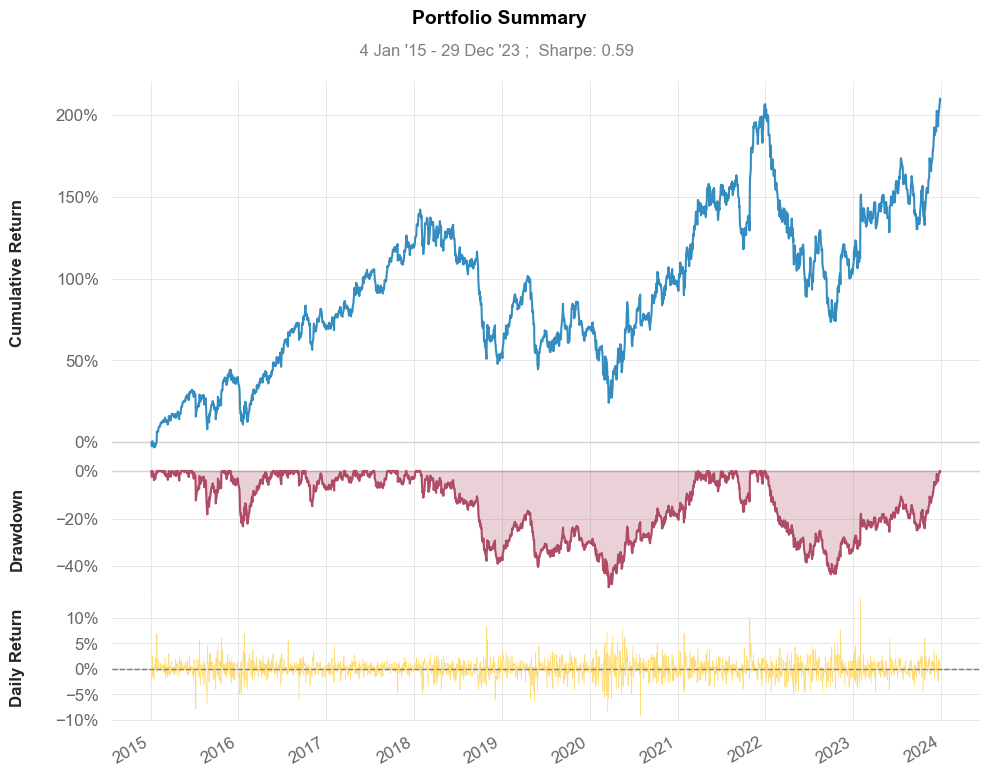

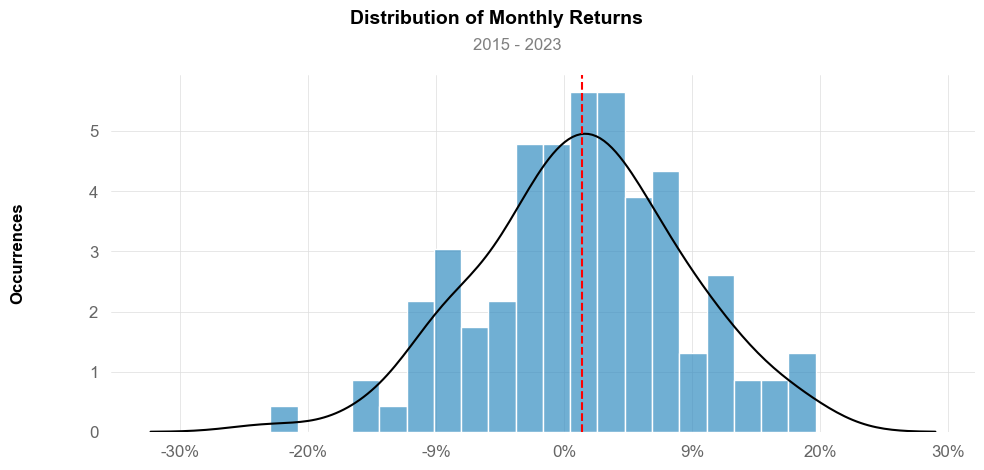

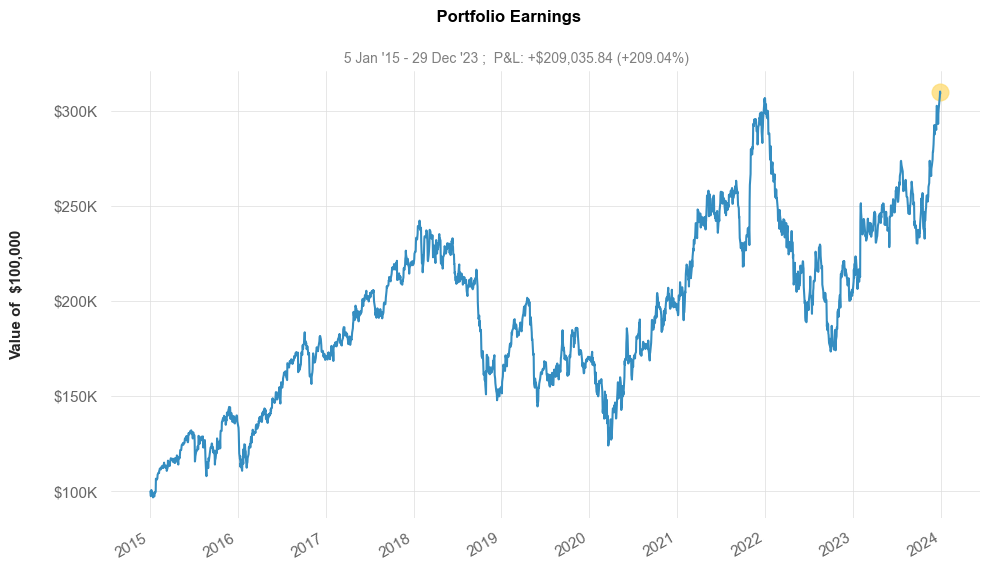

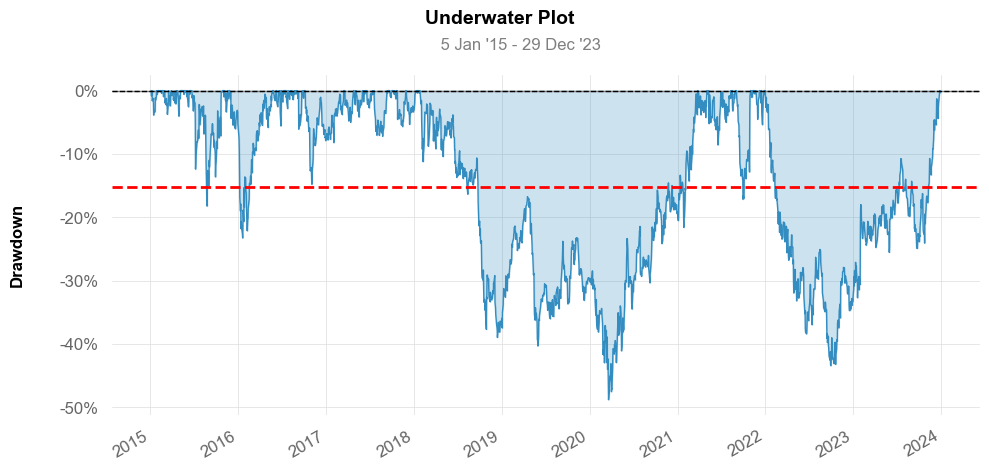

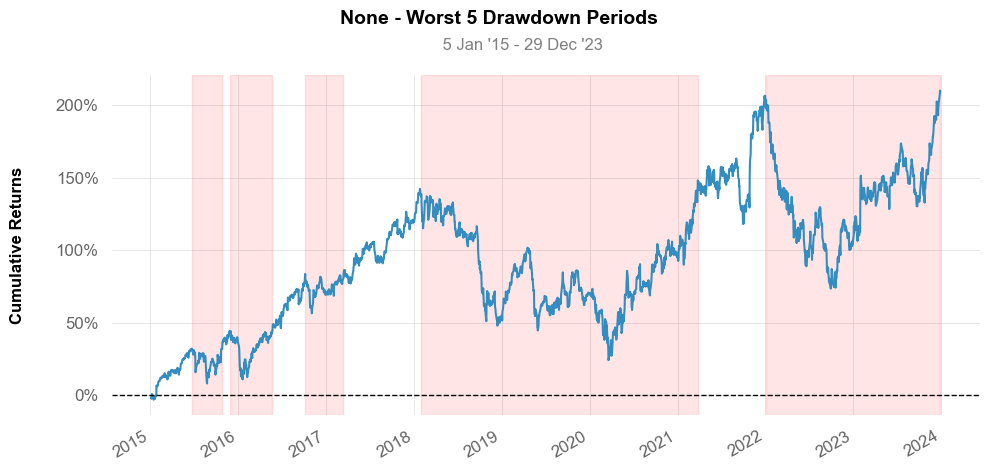

In [169]:
# Generate QuantStats Tearsheet
qs.extend_pandas()  # Extend pandas functionality with QuantStats
#qs.reports.full(portfolio_daily_returns, benchmark=sp500_daily_returns)

# Additional Plots
qs.plots.returns(portfolio_daily_returns)
qs.plots.monthly_returns(portfolio_daily_returns)
qs.plots.rolling_beta(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.rolling_sharpe(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.rolling_sortino(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.rolling_volatility(portfolio_daily_returns, benchmark=sp500_daily_returns)
qs.plots.snapshot(portfolio_daily_returns)
qs.plots.histogram(portfolio_daily_returns)
qs.plots.earnings(portfolio_daily_returns)
qs.plots.drawdown(portfolio_daily_returns)
qs.plots.drawdowns_periods(portfolio_daily_returns)

Generating Pyfolio Tearsheet...


c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\pyfolio\plotting.py:670: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '13.388%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\pyfolio\plotting.py:1407: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

c:\Users\merch\AppData\Local\r-miniconda\envs\quant_lab2\Lib\site-packages\pyfolio\tears.py:1005: UserWarning:

Passed returns do not overlap with anyinteresting times.



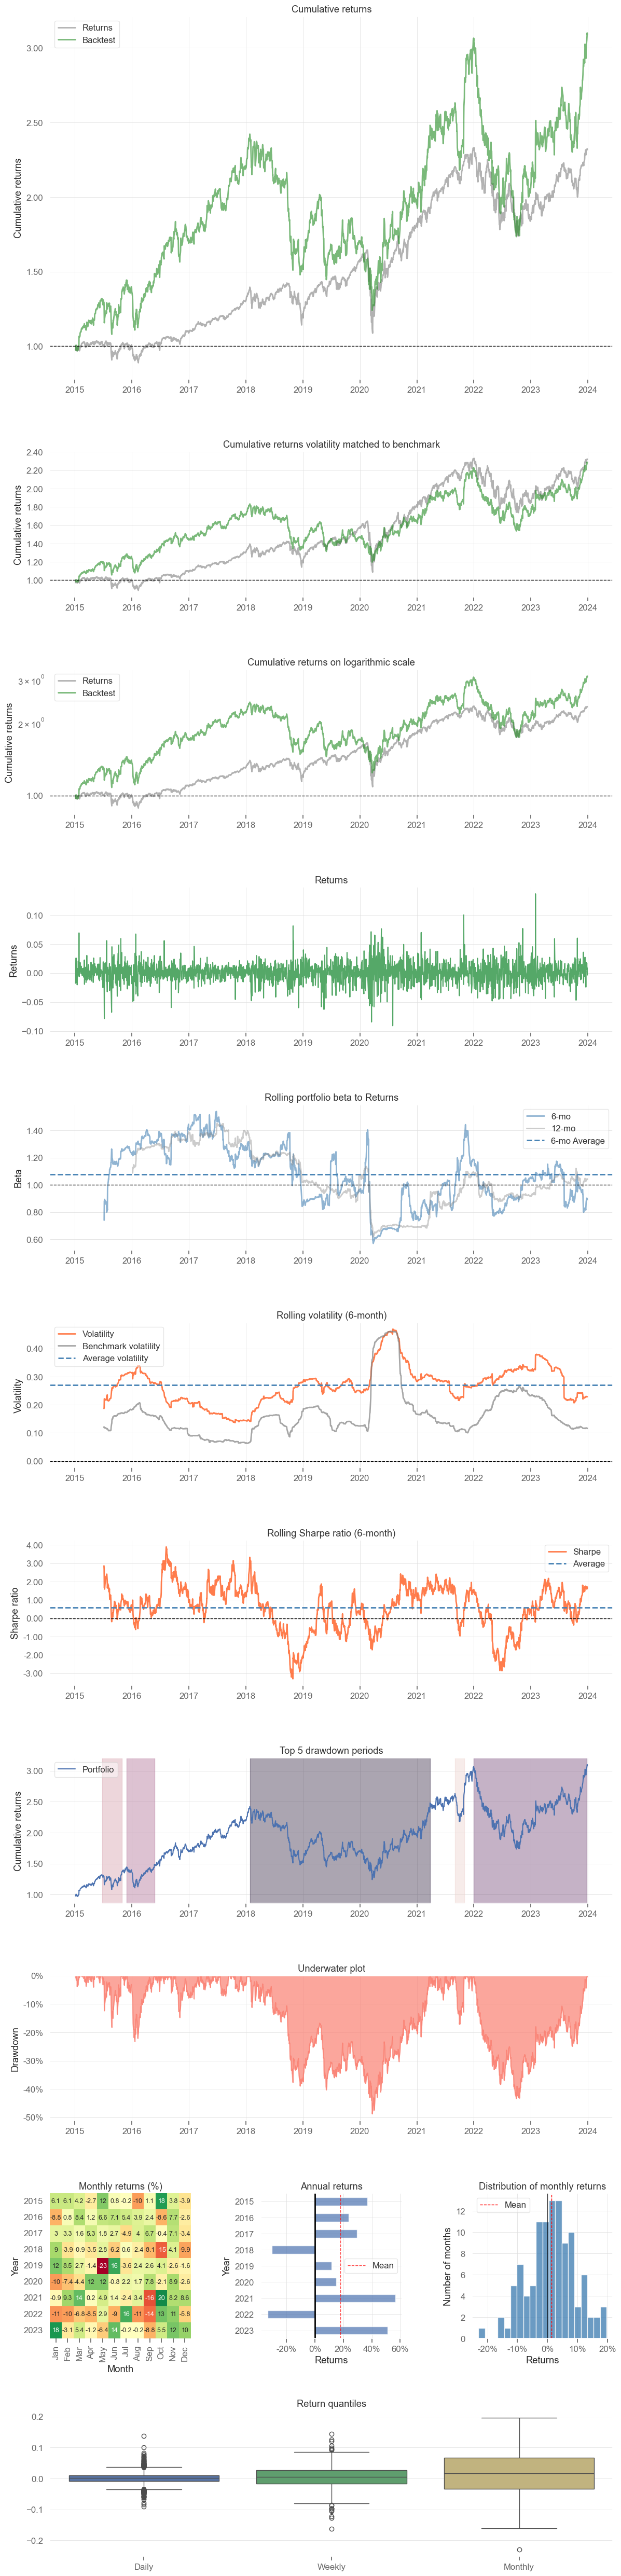

In [170]:
# Generate Tearsheets using Pyfolio
print("Generating Pyfolio Tearsheet...")
pf.create_full_tear_sheet(
    returns=portfolio_daily_returns,
    benchmark_rets=sp500_daily_returns,
    set_context=False
)

# Best Model

# Portfolio Optimization